<a href="https://colab.research.google.com/github/motoroko/Classification-of-Malaria-in-Red-Blood-Cells/blob/main/Classification_of_Malaria_in_Red_Blood_Cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [ ]:
# Import the necessary packages
from keras.models import Sequential
from keras.applications.vgg19 import VGG19
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.models import Model
from keras.layers import Dropout
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from keras.callbacks import CSVLogger
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# Select the Optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import sklearn.metrics as metrics

import os
from os import listdir

import numpy as np
from numpy import asarray
from numpy import save
from numpy import load as np_load

import random
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

import json
from json import dump, load

import seaborn as sn
import pandas as pd
import itertools

In [ ]:
# define location of dataset
#folder = '/content/drive/My Drive/Colab Notebooks/Dataset/'
folder = '/content/drive/MyDrive/Dataset/'

# Functions

## Define CNN VGG19 Model

In [ ]:
def define_model(optimizer='Adam',learning_rate=0.001,dropout=.0,dropout_end=.1,input_shape=(64,64,3)):
	# load model
  model = VGG19(include_top=False, input_shape=input_shape)

  # mark loaded layers as not trainable
  updated_model = Sequential()
  for layer in model.layers:
    layer.trainable = False
    updated_model.add(layer)
    if layer.name[-4:] == 'pool':
      updated_model.add(Dropout(dropout))

  model = updated_model

	# add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  dropout = Dropout(dropout_end)(class1)
  output = Dense(1, activation='sigmoid')(dropout)

	# define new model
  model = Model(inputs=model.inputs, outputs=output)

  # compile model
  if  optimizer == 'Adam' :
    optimizer = Adam(learning_rate=learning_rate)
  elif optimizer == 'SGD' :
    optimizer = SGD(learning_rate=learning_rate)
  elif optimizer == 'RMSprop' :
    optimizer = RMSprop(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  return model

## Summarize Diagnostics Plot

In [ ]:
def summarize_diagnostics(history):
  lens = history['loss'].shape[0]
  history['loss'].index = np.arange(1,lens+1,1)
  history['val_loss'].index = np.arange(1,lens+1,1)
  # plot loss
  fig = plt.figure(figsize=(25,8))
  plt.subplot(121)
  plt.title('Cross Entropy Loss')
  plt.plot(history['loss'], 'b.--', label='train', linewidth = 2,ms=15)
  plt.plot(history['val_loss'], 'r*--', label='test', linewidth = 2,ms=15)
  plt.xlabel('Epochs')
  plt.ylabel('Loss Value')
  plt.xticks(np.arange(0,lens+2,1))
  plt.grid(color = 'black', linestyle = '--', linewidth = 1)
  plt.legend()

  history['accuracy'].index = np.arange(1,lens+1,1)
  history['val_accuracy'].index = np.arange(1,lens+1,1)
  # plot accuracy
  plt.subplot(122)
  plt.title('Classification Accuracy')
  plt.plot(history['accuracy'], 'b.--', label='train', linewidth = 2,ms=15)
  plt.plot(history['val_accuracy'], 'r*--', label='test', linewidth = 2,ms=15)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy Value')
  plt.xticks(np.arange(0,lens+2,1))
  plt.grid(color = 'black', linestyle = '--', linewidth = 1)
  plt.legend()

  plt.tight_layout()
  plt.show()

# Data Preprocessing

## Image reading & Image Processing Size 64x64

In [ ]:
try:
  # load and confirm the shape
  print('Loading Dataset')
  print('-------------------')
  photos = np_load(folder + '64x64_Citra_Asli_Photos.npy',allow_pickle=True)
  labels = np_load(folder + '64x64_Citra_Asli_Labels.npy',allow_pickle=True)
  print('Sucess Load Dataset')
  print('-------------------')
  print(photos.shape, labels.shape)
except:
  print('Dataset not found, creating Dataset')
  print('-------------------')
  photos, labels = list(), list()
  # enumerate files in the directory
  for subfolder in listdir(folder):
    if subfolder in ['Uninfected','Parasitized']:
      # determine class
      output = 0. if subfolder == 'Uninfected' else 1.
      for file in random.sample(listdir(folder+subfolder),2000):
        # Load Image
        image = cv2.imread(folder + subfolder + '/' + file)

        # Resize Image to 64x64
        image = cv2.resize(image,(64,64))

        # convert to numpy array
        image = img_to_array(image)

        # store
        photos.append(image)
        labels.append(output)

  print('Convert and Saving')
  print('-------------------')
  # convert to a numpy arrays
  photos = asarray(photos)
  labels = asarray(labels)
  print(photos.shape, labels.shape)
  print('Saving')
  print('-------------------')
  # save the reshaped photos
  save(folder + '64x64_Citra_Asli_Photos.npy', photos)
  save(folder + '64x64_Citra_Asli_Labels.npy', labels)

Loading Dataset
-------------------
Sucess Load Dataset
-------------------
(4000, 64, 64, 3) (4000,)


Input Image as numpy array

In [ ]:
dataset_photos_64 = np.array(photos)
for idx in range(dataset_photos_64.shape[0]):
  dataset_photos_64[idx] = cv2.cvtColor(dataset_photos_64[idx], cv2.COLOR_BGR2RGB)
dataset_photos_64.shape

(4000, 64, 64, 3)

In [ ]:
labels = np.array(labels)
labels.shape

(4000,)

## Image reading & Image Processing Size 64x64

In [ ]:
try:
  # load and confirm the shape
  print('Loading Dataset')
  print('-------------------')
  photos = np_load(folder + '128x128_Citra_Asli_Photos.npy',allow_pickle=True)
  labels = np_load(folder + '128x128_Citra_Asli_Labels.npy',allow_pickle=True)
  print('Sucess Load Dataset')
  print('-------------------')
  print(photos.shape, labels.shape)
except:
  print('Dataset not found, creating Dataset')
  print('-------------------')
  photos, labels = list(), list()
  # enumerate files in the directory
  for subfolder in listdir(folder):
    if subfolder in ['Uninfected','Parasitized']:
      # determine class
      output = 0. if subfolder == 'Uninfected' else 1.
      for file in random.sample(listdir(folder+subfolder),2000):
        # Load Image
        image = cv2.imread(folder + subfolder + '/' + file)

        # Resize Image to 128x128
        image = cv2.resize(image,(128,128))

        # convert to numpy array
        image = img_to_array(image)

        # store
        photos.append(image)
        labels.append(output)

  print('Convert and Saving')
  print('-------------------')
  # convert to a numpy arrays
  photos = asarray(photos)
  labels = asarray(labels)
  print(photos.shape, labels.shape)
  print('Saving')
  print('-------------------')
  # save the reshaped photos
  save(folder + '128x128_Citra_Asli_Photos.npy', photos)
  save(folder + '128x128_Citra_Asli_Labels.npy', labels)

Loading Dataset
-------------------
Sucess Load Dataset
-------------------
(4000, 128, 128, 3) (4000,)


Input Image as numpy array

In [ ]:
dataset_photos_128 = np.array(photos)
for idx in range(dataset_photos_128.shape[0]):
  dataset_photos_128[idx] = cv2.cvtColor(dataset_photos_128[idx], cv2.COLOR_BGR2RGB)
dataset_photos_128.shape

(4000, 128, 128, 3)

In [ ]:
labels = np.array(labels)
labels.shape

(4000,)

## Image reading & Image Processing Size 256x256

In [ ]:
try:
  # load and confirm the shape
  print('Loading Dataset')
  print('-------------------')
  photos = np_load(folder + '256x256_Citra_Asli_Photos.npy',allow_pickle=True)
  labels = np_load(folder + '256x256_Citra_Asli_Labels.npy',allow_pickle=True)
  print('Sucess Load Dataset')
  print('-------------------')
  print(photos.shape, labels.shape)
except:
  print('Dataset not found, creating Dataset')
  print('-------------------')
  photos, labels = list(), list()
  # enumerate files in the directory
  for subfolder in listdir(folder):
    if subfolder in ['Uninfected','Parasitized']:
      # determine class
      output = 0. if subfolder == 'Uninfected' else 1.
      for file in random.sample(listdir(folder+subfolder),2000):
        # Load Image
        image = cv2.imread(folder + subfolder + '/' + file)

        # Resize Image to 256x256
        image = cv2.resize(image,(256,256))

        # convert to numpy array
        image = img_to_array(image)

        # store
        photos.append(image)
        labels.append(output)

  print('Convert and Saving')
  print('-------------------')
  # convert to a numpy arrays
  photos = asarray(photos)
  labels = asarray(labels)
  print(photos.shape, labels.shape)
  print('Saving')
  print('-------------------')
  # save the reshaped photos
  save(folder + '256x256_Citra_Asli_Photos.npy', photos)
  save(folder + '256x256_Citra_Asli_Labels.npy', labels)

Loading Dataset
-------------------
Sucess Load Dataset
-------------------
(4000, 256, 256, 3) (4000,)


Input Image as numpy array

In [ ]:
dataset_photos_256 = np.array(photos)
for idx in range(dataset_photos_256.shape[0]):
  dataset_photos_256[idx] = cv2.cvtColor(dataset_photos_256[idx], cv2.COLOR_BGR2RGB)
dataset_photos_256.shape

(4000, 256, 256, 3)

In [ ]:
labels = np.array(labels)
labels.shape

(4000,)

# 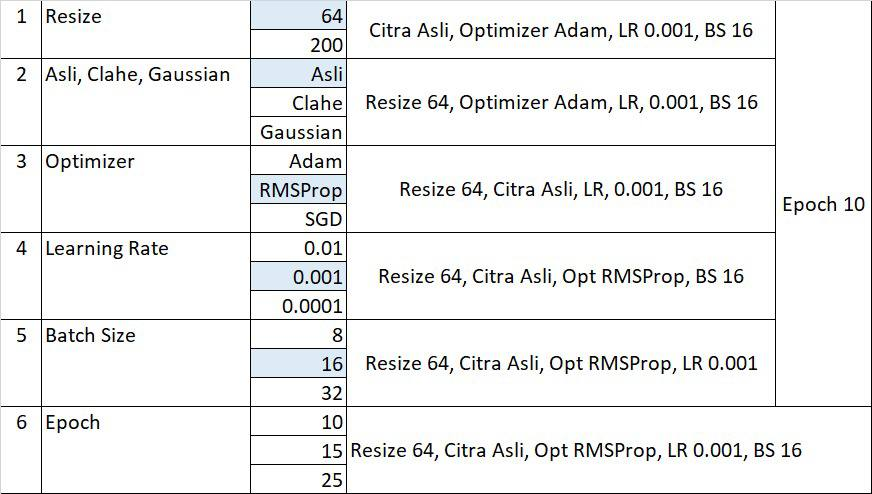

# 1.**Resize**

In [ ]:
resize_acc = []
eval_acc_train,eval_loss_train = [],[]
eval_acc_test,eval_loss_test = [],[]

## Resize 64
Citra Asli, Optimizer = Adam, LR = 0.001,BS = 16, Epochs = 10

In [ ]:
set_name = 'Resize 64,Citra Asli,Optimizer Adam,LR 0.001,BS 16,Epochs 10'

In [ ]:
photos = dataset_photos_64

optimizer = 'Adam'
learning_rate = 0.001
batch_size = 16
epochs = 10
dropout = .0
dropout_end =.0

In [ ]:
model_params = dict(optimizer=optimizer,learning_rate=learning_rate,dropout=dropout,dropout_end=dropout_end)
model_params

{'dropout': 0.0,
 'dropout_end': 0.0,
 'learning_rate': 0.001,
 'optimizer': 'Adam'}

In [ ]:
fit_params = dict(epochs=epochs,batch_size=batch_size)
fit_params

{'batch_size': 16, 'epochs': 10}

Split Data Image into Train and Test Data

In [ ]:
# Split the test data and training data
(trainX, testX, trainY, testY) = train_test_split(photos.copy(), labels.copy(), test_size=0.25, random_state = 0)
print(trainX.shape)
print(testX.shape)

(3000, 64, 64, 3)
(1000, 64, 64, 3)


Normalize our Image matrix into [0 .. 1] range

In [ ]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Image Preview

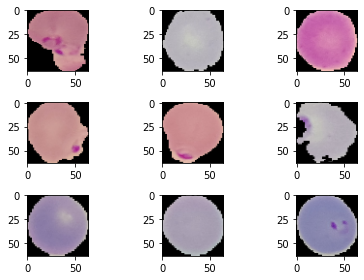

In [ ]:
# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[random.randint(0,trainX.shape[0])]);
# show the figure
plt.tight_layout()
plt.show()

### Training Data

In [ ]:
model = define_model(input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3]),**model_params)

In [ ]:
print('Load Model')
print('-------------------')
csv_logger = CSVLogger(folder + set_name + '.log', separator=',', append=False)
try:
  model = load_model(folder + set_name + '.h5')
  print('Success Load Model')
  print('-------------------')
except:
  print('Model not found in directory\nCreating new Model')
  print('-------------------')
  model.fit(trainX, trainY, validation_data=(testX, testY),callbacks=[csv_logger], **fit_params)
  model.save(folder + set_name + '.h5')
  print('Model Created and Saved')
  print('-------------------')

Load Model
-------------------
Success Load Model
-------------------


### Plot diagnostic learning curves

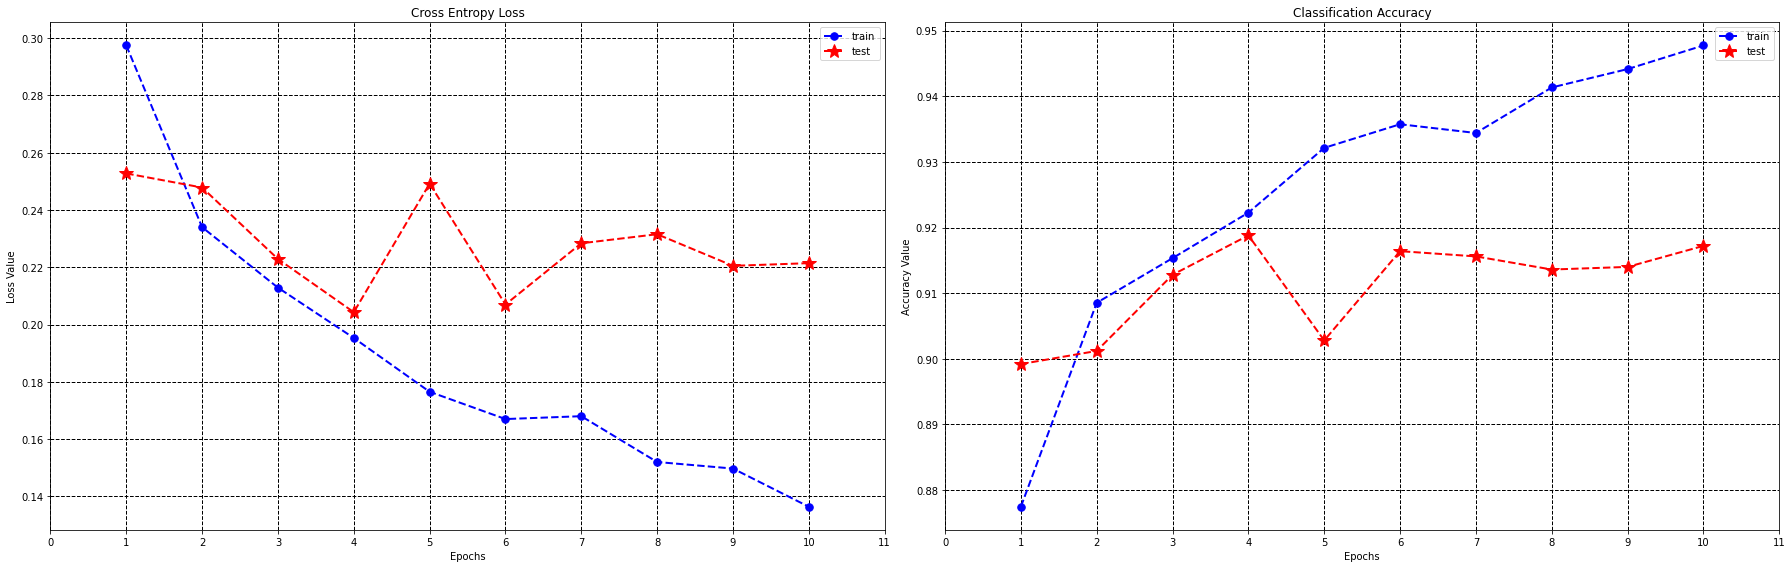

In [ ]:
log_data = pd.read_csv(folder + set_name + '.log', sep=',', engine='python')
summarize_diagnostics(log_data)

In [ ]:
#ini buat training :
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=1)
eval_acc_train.append(train_accuracy)
eval_loss_train.append(train_loss)

#ini buat testing :
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=1)
eval_acc_test.append(test_accuracy)
eval_loss_test.append(test_loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 34s 1s/step - loss: 0.1974 - accuracy: 0.9280


### Prediction

In [ ]:
predictions = model.predict(testX, fit_params['batch_size'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Rescale output Prediction into 0.0 or 1.0 value

In [ ]:
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

(1000, 1)

Reshape TestY

In [ ]:
testY = testY.reshape(testY.shape[0],1)

### Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[474,  34],
       [ 38, 454]])

### Classification Report

In [ ]:
target_names=['Parasitized','Uninfected']

print(classification_report(testY,predictions,target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.93      0.93      0.93       508
  Uninfected       0.93      0.92      0.93       492

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
resize_acc.append(acc)
print('Accuracy : %.5f' % acc)

Accuracy : 0.92800


### Heatmap

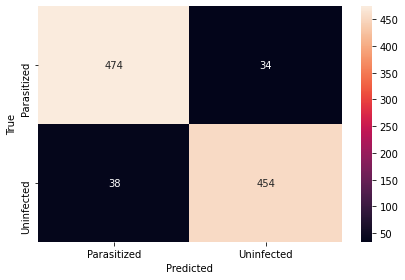

In [ ]:
x_axis_labels = ['Parasitized','Uninfected']
y_axis_labels = ['Parasitized','Uninfected']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Resize 128
Citra Asli, Optimizer = Adam, LR = 0.001,BS = 16, Epochs = 10

In [ ]:
set_name = 'Resize 128,Citra Asli,Optimizer Adam,LR 0.001,BS 16,Epochs 10'

In [ ]:
photos = dataset_photos_128

optimizer = 'Adam'
learning_rate = 0.001
batch_size = 16
epochs = 10
dropout = .0
dropout_end =.0

In [ ]:
model_params = dict(optimizer=optimizer,learning_rate=learning_rate,dropout=dropout,dropout_end=dropout_end)
model_params

{'dropout': 0.0,
 'dropout_end': 0.0,
 'learning_rate': 0.001,
 'optimizer': 'Adam'}

In [ ]:
fit_params = dict(epochs=epochs,batch_size=batch_size)
fit_params

{'batch_size': 16, 'epochs': 10}

Split Data Image into Train and Test Data

In [ ]:
# Split the test data and training data
(trainX, testX, trainY, testY) = train_test_split(photos.copy(), labels.copy(), test_size=0.25, random_state = 0)
print(trainX.shape)
print(testX.shape)

(3000, 128, 128, 3)
(1000, 128, 128, 3)


Normalize our Image matrix into [0 .. 1] range

In [ ]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Image Preview

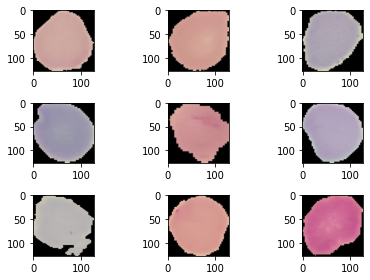

In [ ]:
# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[random.randint(0,trainX.shape[0])]);
# show the figure
plt.tight_layout()
plt.show()

### Training Data

In [ ]:
model = define_model(input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3]),**model_params)

In [ ]:
print('Load Model')
print('-------------------')
csv_logger = CSVLogger(folder + set_name + '.log', separator=',', append=False)
try:
  model = load_model(folder + set_name + '.h5')
  print('Success Load Model')
  print('-------------------')
except:
  print('Model not found in directory\nCreating new Model')
  print('-------------------')
  model.fit(trainX, trainY, validation_data=(testX, testY),callbacks=[csv_logger], **fit_params)
  model.save(folder + set_name + '.h5')
  print('Model Created and Saved')
  print('-------------------')

Load Model
-------------------
Success Load Model
-------------------


### Plot diagnostic learning curves

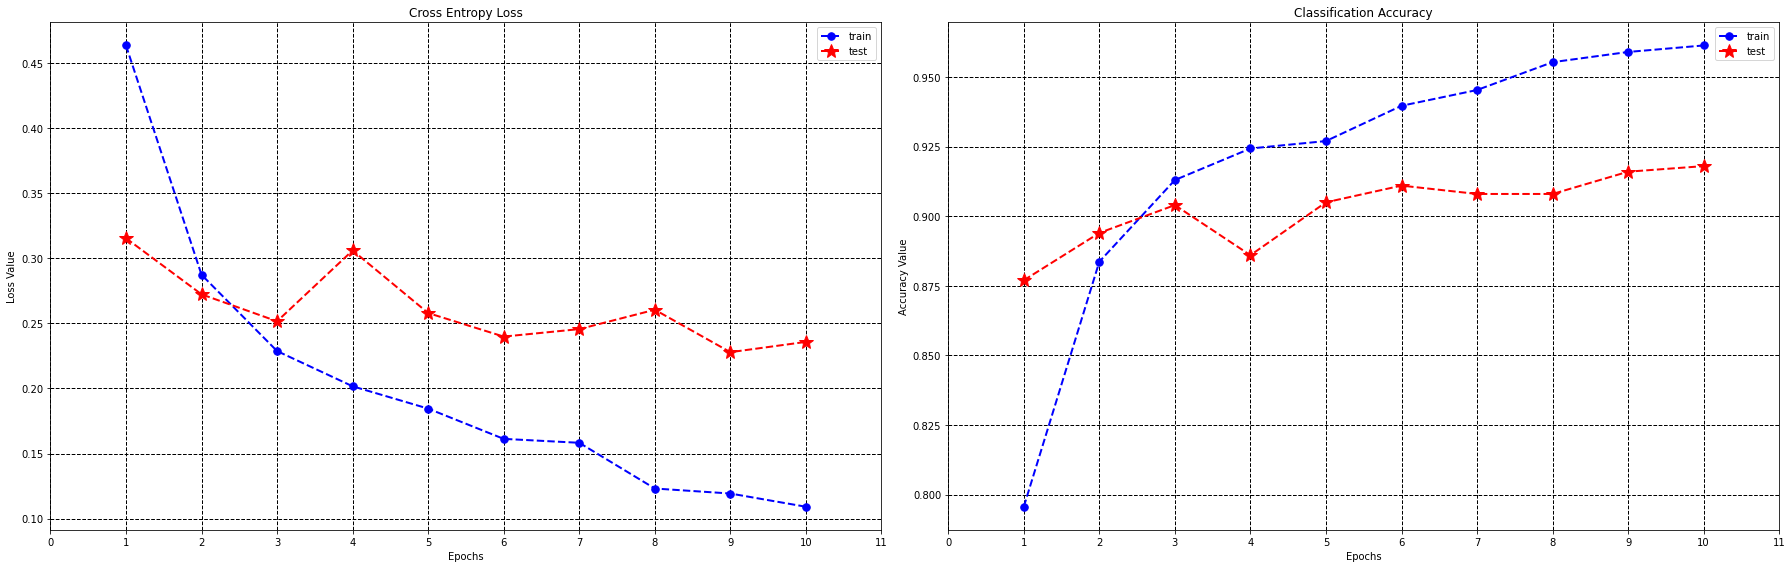

In [ ]:
log_data = pd.read_csv(folder + set_name + '.log', sep=',', engine='python')
summarize_diagnostics(log_data)

In [ ]:
#ini buat training :
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=1)
eval_acc_train.append(train_accuracy)
eval_loss_train.append(train_loss)

#ini buat testing :
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=1)
eval_acc_test.append(test_accuracy)
eval_loss_test.append(test_loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 131s 4s/step - loss: 0.2358 - accuracy: 0.9180


### Prediction

In [ ]:
predictions = model.predict(testX, fit_params['batch_size'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Rescale output Prediction into 0.0 or 1.0 value

In [ ]:
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

(1000, 1)

Reshape TestY

In [ ]:
testY = testY.reshape(testY.shape[0],1)

### Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[461,  47],
       [ 35, 457]])

### Classification Report

In [ ]:
target_names=['Parasitized','Uninfected']

print(classification_report(testY,predictions,target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.93      0.91      0.92       508
  Uninfected       0.91      0.93      0.92       492

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
resize_acc.append(acc)
print('Accuracy : %.5f' % acc)

Accuracy : 0.91800


### Heatmap

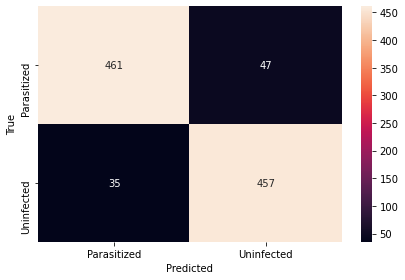

In [ ]:
x_axis_labels = ['Parasitized','Uninfected']
y_axis_labels = ['Parasitized','Uninfected']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Resize 256
Citra Asli, Optimizer = Adam, LR = 0.001,BS = 16, Epochs = 10

In [ ]:
set_name = 'Resize 256,Citra Asli,Optimizer Adam,LR 0.001,BS 16,Epochs 10'

In [ ]:
photos = dataset_photos_256

optimizer = 'Adam'
learning_rate = 0.001
batch_size = 16
epochs = 10
dropout = .0
dropout_end =.0

In [ ]:
model_params = dict(optimizer=optimizer,learning_rate=learning_rate,dropout=dropout,dropout_end=dropout_end)
model_params

{'dropout': 0.0,
 'dropout_end': 0.0,
 'learning_rate': 0.001,
 'optimizer': 'Adam'}

In [ ]:
fit_params = dict(epochs=epochs,batch_size=batch_size)
fit_params

{'batch_size': 16, 'epochs': 10}

Split Data Image into Train and Test Data

In [ ]:
# Split the test data and training data
(trainX, testX, trainY, testY) = train_test_split(photos, labels, test_size=0.25, random_state = 0)
print(trainX.shape)
print(testX.shape)

(3000, 256, 256, 3)
(1000, 256, 256, 3)


Normalize our Image matrix into [0 .. 1] range

In [ ]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Image Preview

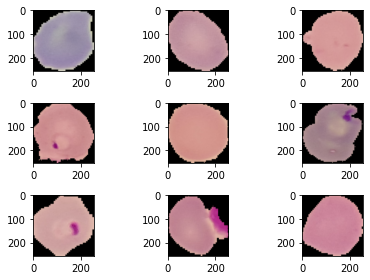

In [ ]:
# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[random.randint(0,trainX.shape[0])]);
# show the figure
plt.tight_layout()
plt.show()

### Training Data

In [ ]:
model = define_model(input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3]),**model_params)

In [ ]:
print('Load Model')
print('-------------------')
csv_logger = CSVLogger(folder + set_name + '.log', separator=',', append=False)
try:
  model = load_model(folder + set_name + '.h5')
  print('Success Load Model')
  print('-------------------')
except:
  print('Model not found in directory\nCreating new Model')
  print('-------------------')
  model.fit(trainX, trainY, validation_data=(testX, testY),callbacks=[csv_logger], **fit_params)
  model.save(folder + set_name + '.h5')
  print('Model Created and Saved')
  print('-------------------')

Load Model
-------------------
Success Load Model
-------------------


### Plot diagnostic learning curves

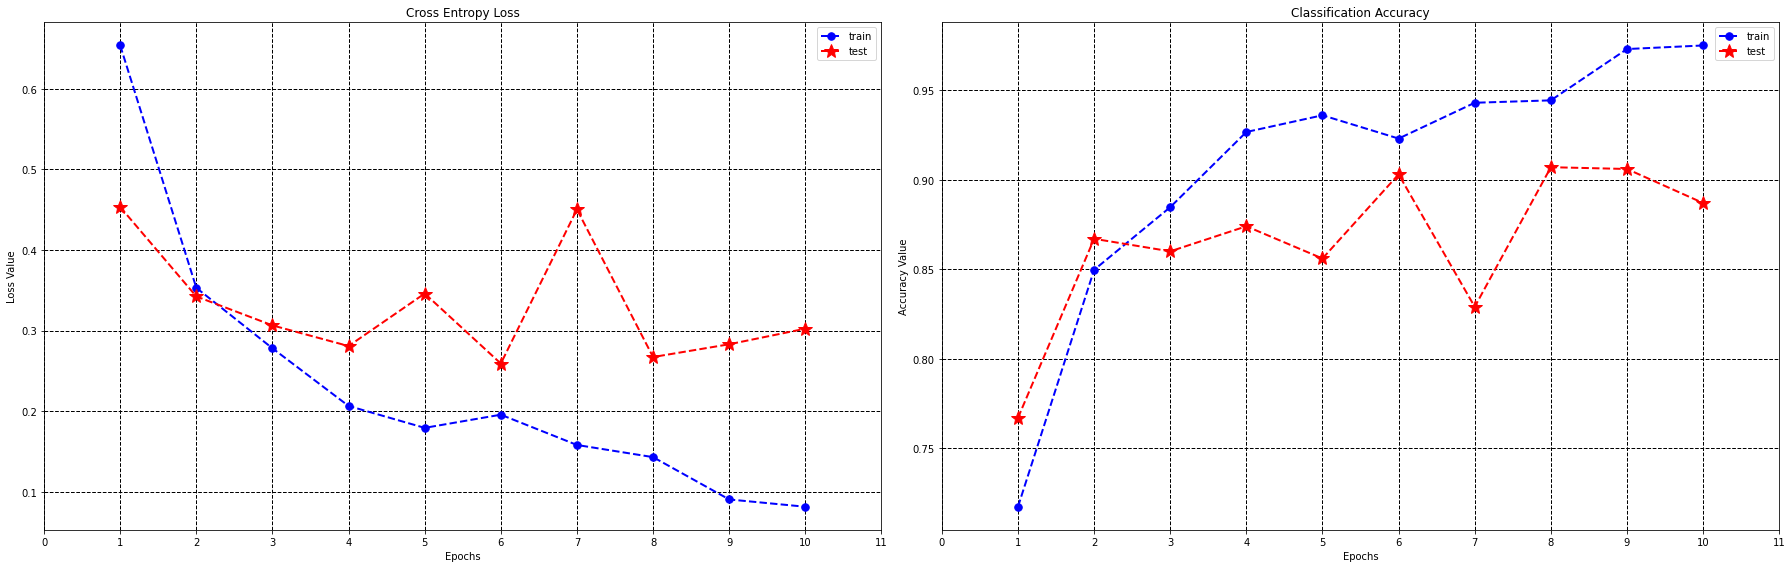

In [ ]:
log_data = pd.read_csv(folder + set_name + '.log', sep=',', engine='python')
summarize_diagnostics(log_data)

In [ ]:
#ini buat training :
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=1)
eval_acc_train.append(train_accuracy)
eval_loss_train.append(train_loss)

#ini buat testing :
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=1)
eval_acc_test.append(test_accuracy)
eval_loss_test.append(test_loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 524s 16s/step - loss: 0.3023 - accuracy: 0.8870


### Prediction

In [ ]:
predictions = model.predict(testX, fit_params['batch_size'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Rescale output Prediction into 0.0 or 1.0 value

In [ ]:
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

(1000, 1)

Reshape TestY

In [ ]:
testY = testY.reshape(testY.shape[0],1)

### Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[485,  23],
       [ 90, 402]])

### Classification Report

In [ ]:
target_names=['Parasitized','Uninfected']

print(classification_report(testY,predictions,target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.84      0.95      0.90       508
  Uninfected       0.95      0.82      0.88       492

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
resize_acc.append(acc)
print('Accuracy : %.5f' % acc)

Accuracy : 0.88700


### Heatmap

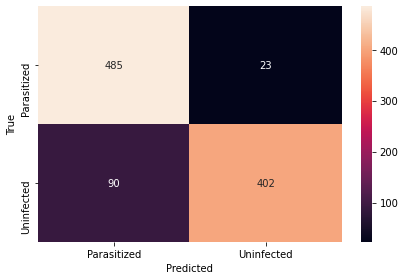

In [ ]:
x_axis_labels = ['Parasitized','Uninfected']
y_axis_labels = ['Parasitized','Uninfected']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Analisis Resize

### Based on Training Evaluate

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


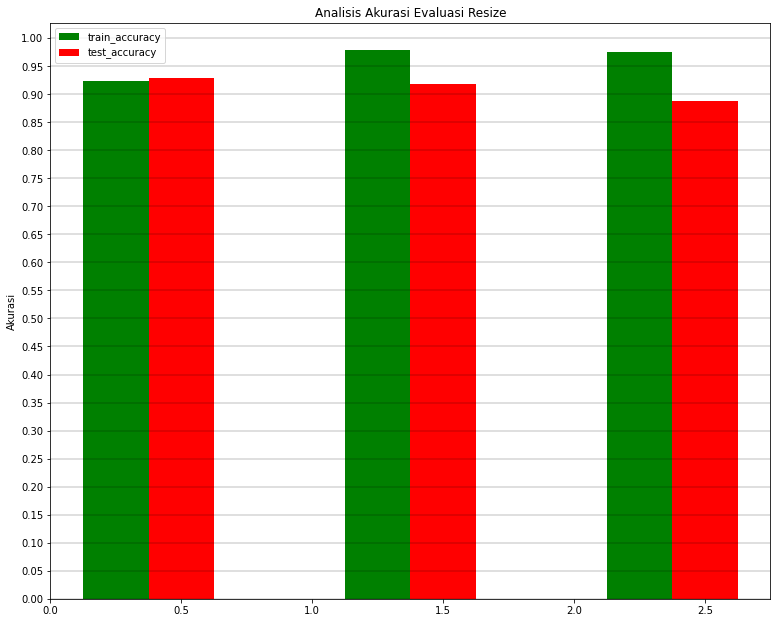

In [ ]:
ind = 0
width = 0.25

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind + 0.25, eval_acc_train[0], width, color='g')
ax.bar(ind + 0.5, eval_acc_test[0], width, color='r')
ax.bar(ind + 1.25, eval_acc_train[1], width, color='g')
ax.bar(ind + 1.5, eval_acc_test[1], width, color='r')
ax.bar(ind + 2.25, eval_acc_train[2], width, color='g')
ax.bar(ind + 2.5, eval_acc_test[2], width, color='r')

ax.set_ylabel('Akurasi')
ax.set_title('Analisis Akurasi Evaluasi Resize')
ax.set_yticks(np.arange(0, 1.05, 0.05))
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.25)
ax.legend(labels=['train_accuracy','test_accuracy'])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


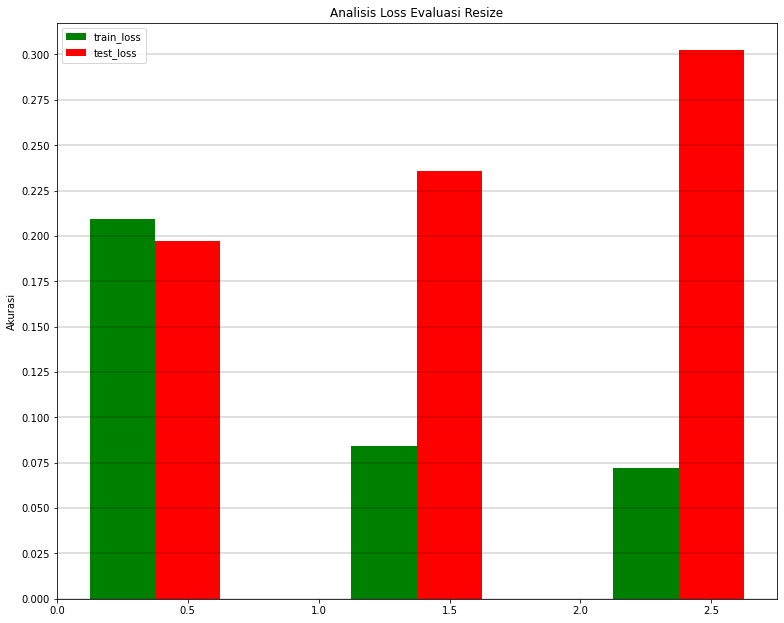

In [ ]:
ind = 0
width = 0.25

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind + 0.25, eval_loss_train[0], width, color='g')
ax.bar(ind + 0.5, eval_loss_test[0], width, color='r')
ax.bar(ind + 1.25, eval_loss_train[1], width, color='g')
ax.bar(ind + 1.5, eval_loss_test[1], width, color='r')
ax.bar(ind + 2.25, eval_loss_train[2], width, color='g')
ax.bar(ind + 2.5, eval_loss_test[2], width, color='r')

ax.set_ylabel('Akurasi')
ax.set_title('Analisis Loss Evaluasi Resize')
ax.set_yticks(np.arange(0, 0.325, 0.025))
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.25)
ax.legend(labels=['train_loss','test_loss'])

plt.tight_layout()
plt.show()

### Based on Predictions Accuracy

In [ ]:
ind = 0
width = 0.25
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind + 0.25, resize_acc[0], width, color='g')
ax.bar(ind + 0.5, resize_acc[1], width, color='r')
ax.bar(ind + 0.75, resize_acc[2], width, color='b')

ax.set_ylabel('Akurasi')
ax.set_title('Analisis Akurasi Resize')
ax.set_yticks(np.arange(0, 1.1, 0.1))
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 1)
ax.legend(labels=['64 x 64','128 x 128','256 x 256'])
plt.show()

TypeError: ignored

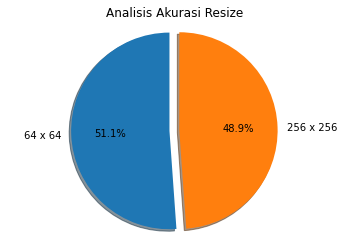

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
label = '64 x 64','128 x 128','256 x 256'
sizes = resize_acc
explode = [0 if i != max(sizes) else 0.1 for i in sizes]

fig1, ax1 = plt.subplots()
plt.title('Analisis Akurasi Resize')
ax1.pie(sizes, explode=explode, labels=label, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
resize_data = [dataset_photos_64,dataset_photos_256]
best_resize = resize_data[np.argmax(resize_acc)]
resize_label = ['64','128','256']
best_resize_name = resize_label[np.argmax(resize_acc)]

In [ ]:
print('Best Resize : ',best_resize_name)

Best Resize :  64


# 2.**Citra**

In [ ]:
citra_acc = []
eval_acc_train,eval_loss_train = [],[]
eval_acc_test,eval_loss_test = [],[]

## Citra Asli
Resize 64, Optimizer = Adam, LR = 0.001, BS = 16, Epochs = 10

In [ ]:
set_name = 'Resize '+best_resize_name+',Citra Asli,Optimizer Adam,LR 0.001,BS 16,Epochs 10'

In [ ]:
photos = best_resize

optimizer = 'Adam'
learning_rate = 0.001
batch_size = 16
epochs = 10
dropout = .0
dropout_end =.0

In [ ]:
model_params = dict(optimizer=optimizer,learning_rate=learning_rate,dropout=dropout,dropout_end=dropout_end)
model_params

{'dropout': 0.0,
 'dropout_end': 0.0,
 'learning_rate': 0.001,
 'optimizer': 'Adam'}

In [ ]:
fit_params = dict(epochs=epochs,batch_size=batch_size)
fit_params

{'batch_size': 16, 'epochs': 10}

Split Data Image into Train and Test Data

In [ ]:
# Split the test data and training data
(trainX, testX, trainY, testY) = train_test_split(photos.copy(), labels.copy(), test_size=0.25, random_state = 0)
print(trainX.shape)
print(testX.shape)

(3000, 64, 64, 3)
(1000, 64, 64, 3)


Normalize our Image matrix into [0 .. 1] range

In [ ]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Image Preview

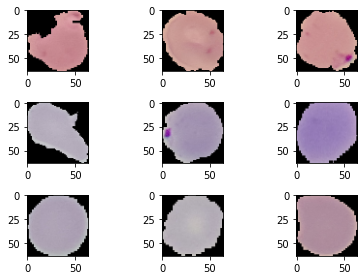

In [ ]:
# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[random.randint(0,trainX.shape[0])]);
# show the figure
plt.tight_layout()
plt.show()

### Training Data

In [ ]:
model = define_model(input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3]),**model_params)

In [ ]:
print('Load Model')
print('-------------------')
csv_logger = CSVLogger(folder + set_name + '.log', separator=',', append=False)
try:
  model = load_model(folder + set_name + '.h5')
  print('Success Load Model')
  print('-------------------')
except:
  print('Model not found in directory\nCreating new Model')
  print('-------------------')
  model.fit(trainX, trainY, validation_data=(testX, testY),callbacks=[csv_logger], **fit_params)
  model.save(folder + set_name + '.h5')
  print('Model Created and Saved')
  print('-------------------')

Load Model
-------------------
Success Load Model
-------------------


### Plot diagnostic learning curves

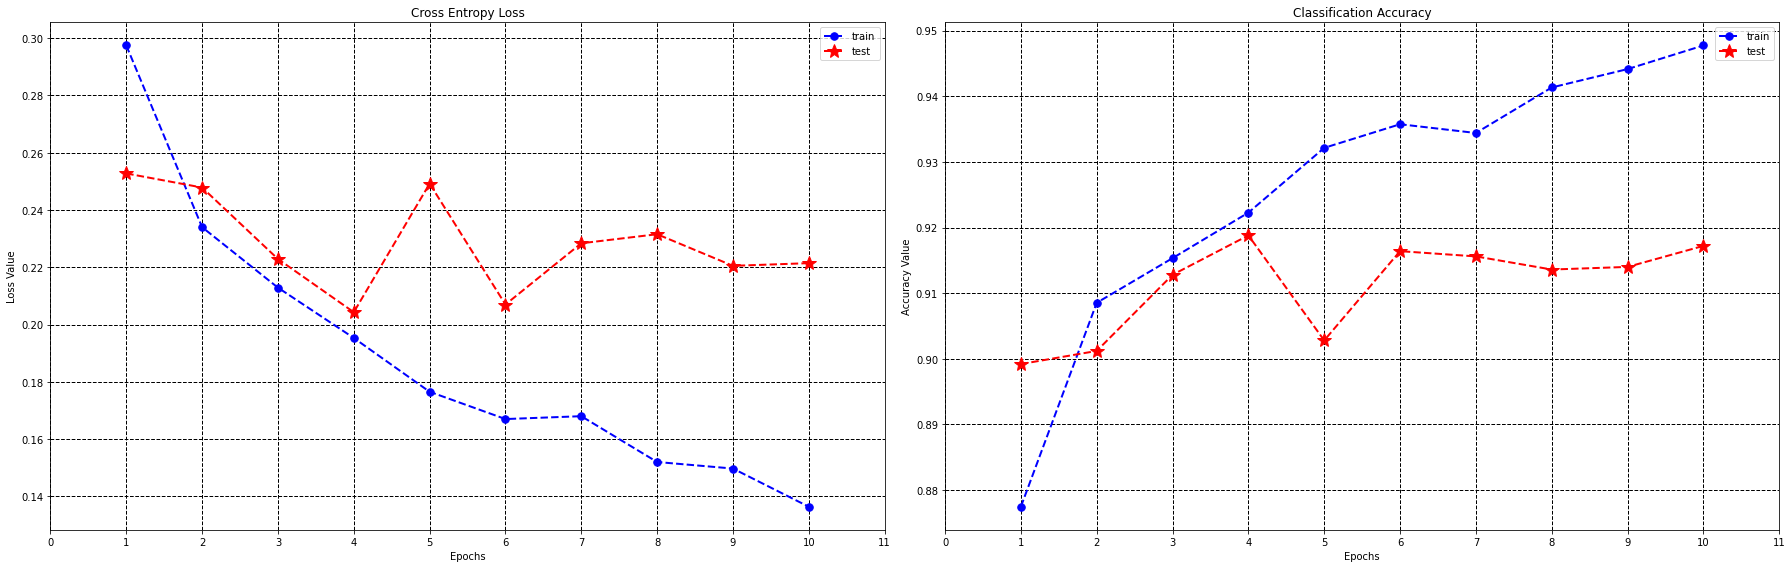

In [ ]:
log_data = pd.read_csv(folder + set_name + '.log', sep=',', engine='python')
summarize_diagnostics(log_data)

In [ ]:
#ini buat training :
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=1)
eval_acc_train.append(train_accuracy)
eval_loss_train.append(train_loss)

#ini buat testing :
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=1)
eval_acc_test.append(test_accuracy)
eval_loss_test.append(test_loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 34s 1s/step - loss: 0.1974 - accuracy: 0.9280


### Prediction

In [ ]:
predictions = model.predict(testX, fit_params['batch_size'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Rescale output Prediction into 0.0 or 1.0 value

In [ ]:
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

(1000, 1)

Reshape TestY

In [ ]:
testY = testY.reshape(testY.shape[0],1)

### Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[474,  34],
       [ 38, 454]])

### Classification Report

In [ ]:
target_names=['Parasitized','Uninfected']

print(classification_report(testY,predictions,target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.93      0.93      0.93       508
  Uninfected       0.93      0.92      0.93       492

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
citra_acc.append(acc)
print('Accuracy : %.5f' % acc)

Accuracy : 0.92800


### Heatmap

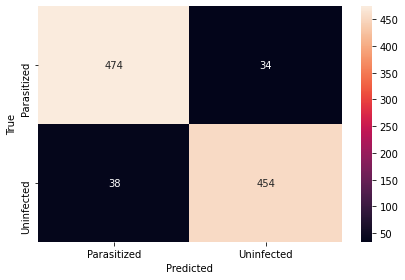

In [ ]:
x_axis_labels = ['Parasitized','Uninfected']
y_axis_labels = ['Parasitized','Uninfected']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Citra Gaussian Filter
Resize 64, Optimizer = Adam, LR = 0.001, BS = 16, Epochs = 10

In [ ]:
set_name = 'Resize '+best_resize_name+',Citra Gaussian,Optimizer Adam,LR 0.001,BS 16,Epochs 10'

Preproses Citra

In [ ]:
photos = best_resize

optimizer = 'Adam'
learning_rate = 0.001
batch_size = 16
epochs = 10
dropout = .0
dropout_end =.0

In [ ]:
Gaussian_photos = photos.copy()
for idx in range(Gaussian_photos.shape[0]):
  image = Gaussian_photos[idx]

  # Change image into Gray and apply Gaussian Filter
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.GaussianBlur(image, (3, 3), 0)

  # Change image back to RGB
  Gaussian_photos[idx] = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
model_params = dict(optimizer=optimizer,learning_rate=learning_rate,dropout=dropout,dropout_end=dropout_end)
model_params

{'dropout': 0.0,
 'dropout_end': 0.0,
 'learning_rate': 0.001,
 'optimizer': 'Adam'}

In [ ]:
fit_params = dict(epochs=epochs,batch_size=batch_size)
fit_params

{'batch_size': 16, 'epochs': 10}

Split Data Image into Train and Test Data

In [ ]:
# Split the test data and training data
(trainX, testX, trainY, testY) = train_test_split(Gaussian_photos.copy(), labels.copy(), test_size=0.25, random_state = 0)
print(trainX.shape)
print(testX.shape)

(3000, 64, 64, 3)
(1000, 64, 64, 3)


Normalize our Image matrix into [0 .. 1] range

In [ ]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Image Preview

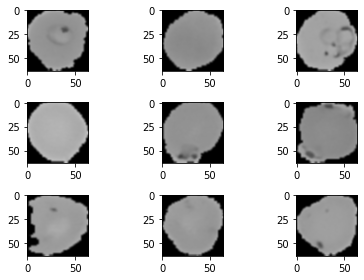

In [ ]:
# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[random.randint(0,trainX.shape[0])]);
# show the figure
plt.tight_layout()
plt.show()

### Training Data

In [ ]:
model = define_model(input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3]),**model_params)

In [ ]:
print('Load Model')
print('-------------------')
csv_logger = CSVLogger(folder + set_name + '.log', separator=',', append=False)
try:
  model = load_model(folder + set_name + '.h5')
  print('Success Load Model')
  print('-------------------')
except:
  print('Model not found in directory\nCreating new Model')
  print('-------------------')
  model.fit(trainX, trainY, validation_data=(testX, testY),callbacks=[csv_logger], **fit_params)
  model.save(folder + set_name + '.h5')
  print('Model Created and Saved')
  print('-------------------')

Load Model
-------------------
Success Load Model
-------------------


### Plot diagnostic learning curves

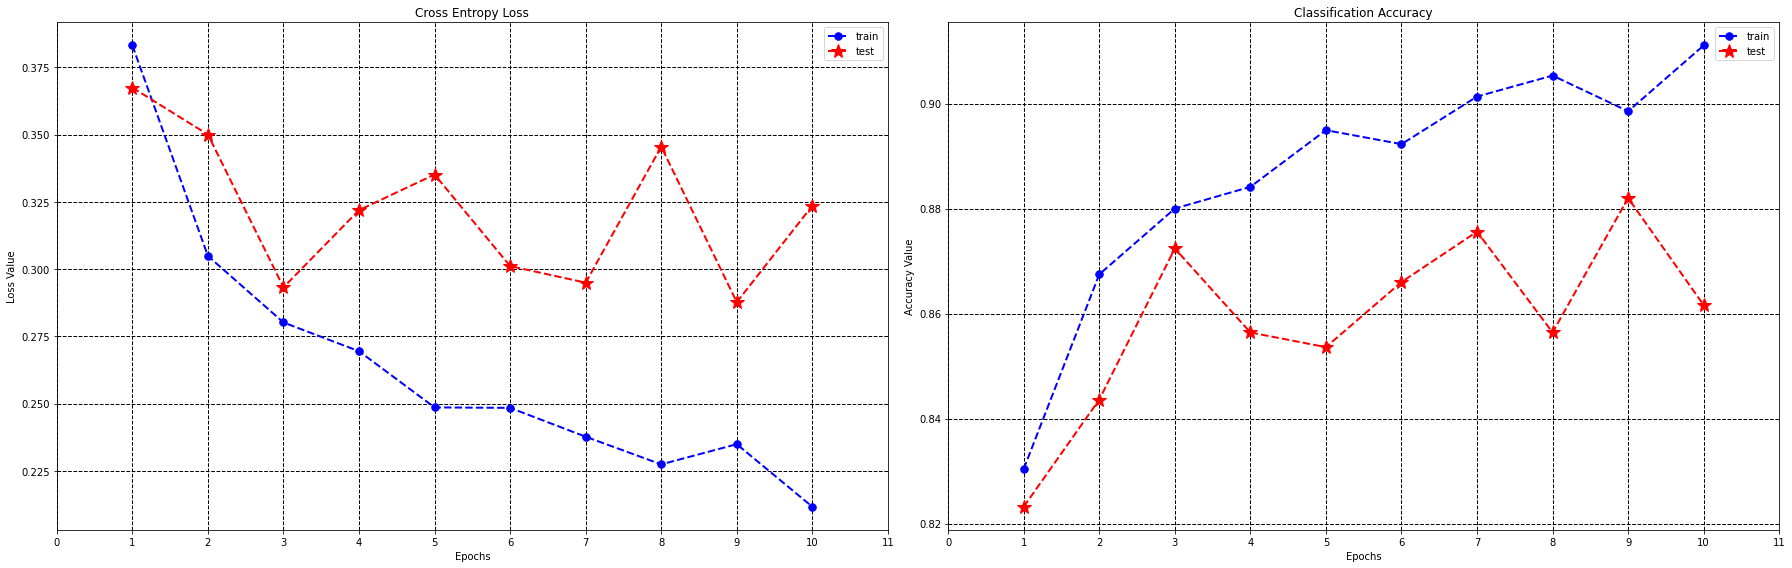

In [ ]:
log_data = pd.read_csv(folder + set_name + '.log', sep=',', engine='python')
summarize_diagnostics(log_data)

In [ ]:
#ini buat training :
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=1)
eval_acc_train.append(train_accuracy)
eval_loss_train.append(train_loss)

#ini buat testing :
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=1)
eval_acc_test.append(test_accuracy)
eval_loss_test.append(test_loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 34s 1s/step - loss: 0.1974 - accuracy: 0.9280


### Prediction

In [ ]:
predictions = model.predict(testX, fit_params['batch_size'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Rescale output Prediction into 0.0 or 1.0 value

In [ ]:
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

(1000, 1)

Reshape TestY

In [ ]:
testY = testY.reshape(testY.shape[0],1)

### Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[484,  24],
       [112, 380]])

### Classification Report

In [ ]:
target_names=['Parasitized','Uninfected']

print(classification_report(testY,predictions,target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.81      0.95      0.88       508
  Uninfected       0.94      0.77      0.85       492

    accuracy                           0.86      1000
   macro avg       0.88      0.86      0.86      1000
weighted avg       0.88      0.86      0.86      1000



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
citra_acc.append(acc)
print('Accuracy : %.5f' % acc)

Accuracy : 0.86400


### Heatmap

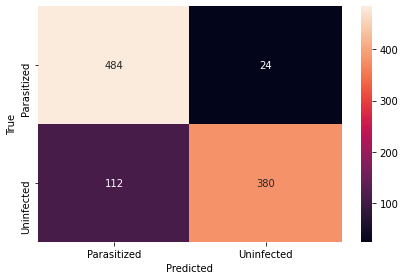

In [ ]:
x_axis_labels = ['Parasitized','Uninfected']
y_axis_labels = ['Parasitized','Uninfected']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Citra Gaussian Filter + CLAHE
Resize 64, Optimizer = Adam, LR = 0.001, BS = 16, Epochs = 10

In [ ]:
set_name = 'Resize '+best_resize_name+',Citra CLAHE,Optimizer Adam,LR 0.001,BS 16,Epochs 10'

Preproses Citra

In [ ]:
photos = best_resize

optimizer = 'Adam'
learning_rate = 0.001
batch_size = 16
epochs = 10
dropout = .0
dropout_end =.0

In [ ]:
CLAHE_photos = photos.copy()
for idx in range(CLAHE_photos.shape[0]):
  image = cv2.imwrite('img.jpg', CLAHE_photos[idx])
  image = cv2.imread('img.jpg')

  # Change image into Gray and apply Gaussian Filter
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.GaussianBlur(image, (3, 3), 0)

  # Apply CLAHE into image
  clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
  image = clahe.apply(image)

  # Change image back to RGB
  CLAHE_photos[idx] = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
model_params = dict(optimizer=optimizer,learning_rate=learning_rate,dropout=dropout,dropout_end=dropout_end)
model_params

{'dropout': 0.0,
 'dropout_end': 0.0,
 'learning_rate': 0.001,
 'optimizer': 'Adam'}

In [ ]:
fit_params = dict(epochs=epochs,batch_size=batch_size)
fit_params

{'batch_size': 16, 'epochs': 10}

Split Data Image into Train and Test Data

In [ ]:
# Split the test data and training data
(trainX, testX, trainY, testY) = train_test_split(CLAHE_photos.copy(), labels.copy(), test_size=0.25, random_state = 0)
print(trainX.shape)
print(testX.shape)

(3000, 64, 64, 3)
(1000, 64, 64, 3)


Normalize our Image matrix into [0 .. 1] range

In [ ]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Image Preview

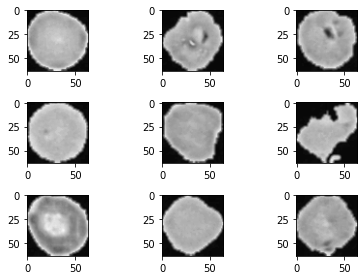

In [ ]:
# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[random.randint(0,trainX.shape[0])]);
# show the figure
plt.tight_layout()
plt.show()

### Training Data

In [ ]:
model = define_model(input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3]),**model_params)

In [ ]:
print('Load Model')
print('-------------------')
csv_logger = CSVLogger(folder + set_name + '.log', separator=',', append=False)
try:
  model = load_model(folder + set_name + '.h5')
  print('Success Load Model')
  print('-------------------')
except:
  print('Model not found in directory\nCreating new Model')
  print('-------------------')
  model.fit(trainX, trainY, validation_data=(testX, testY),callbacks=[csv_logger], **fit_params)
  model.save(folder + set_name + '.h5')
  print('Model Created and Saved')
  print('-------------------')

Load Model
-------------------
Success Load Model
-------------------


### Plot diagnostic learning curves

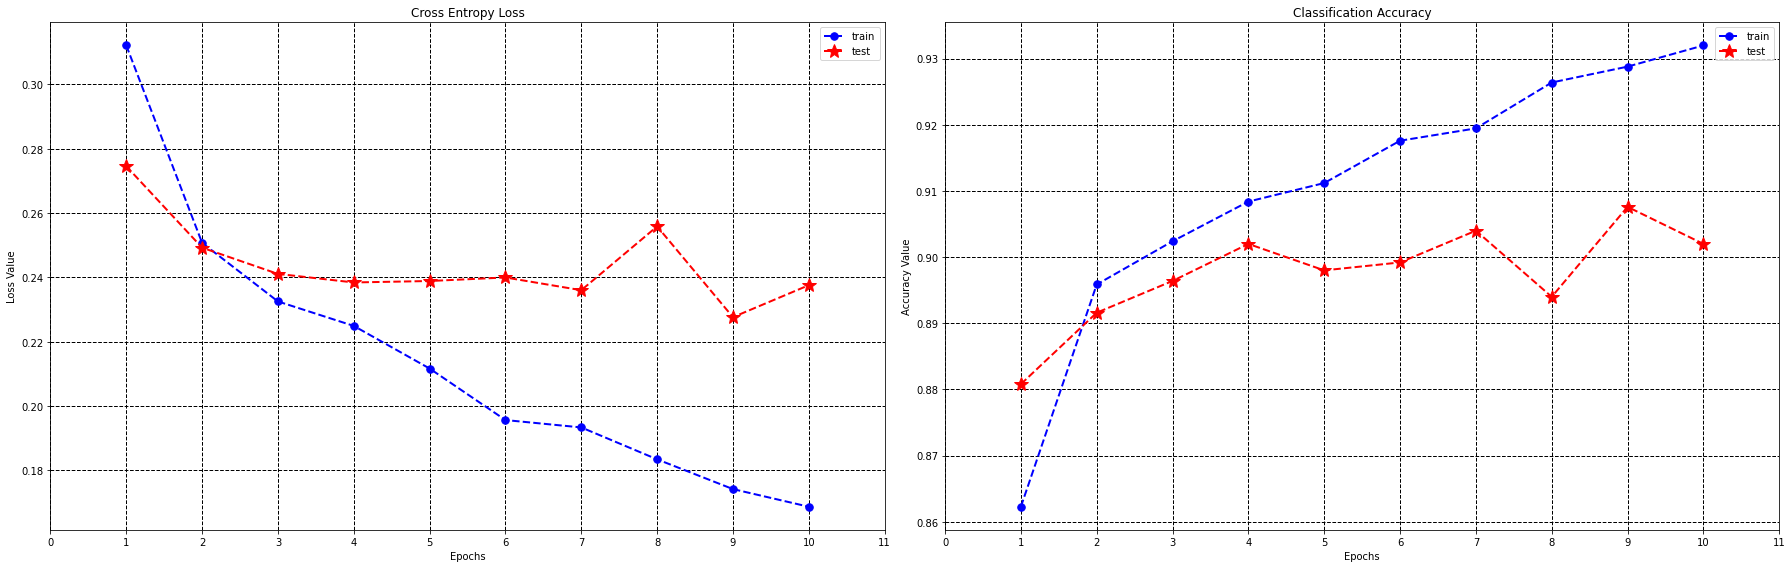

In [ ]:
log_data = pd.read_csv(folder + set_name + '.log', sep=',', engine='python')
summarize_diagnostics(log_data)

In [ ]:
#ini buat training :
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=1)
eval_acc_train.append(train_accuracy)
eval_loss_train.append(train_loss)

#ini buat testing :
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=1)
eval_acc_test.append(test_accuracy)
eval_loss_test.append(test_loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 34s 1s/step - loss: 0.1974 - accuracy: 0.9280


### Prediction

In [ ]:
predictions = model.predict(testX, fit_params['batch_size'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Rescale output Prediction into 0.0 or 1.0 value

In [ ]:
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

(1000, 1)

Reshape TestY

In [ ]:
testY = testY.reshape(testY.shape[0],1)

### Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[473,  35],
       [ 43, 449]])

### Classification Report

In [ ]:
target_names=['Parasitized','Uninfected']

print(classification_report(testY,predictions,target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.92      0.93      0.92       508
  Uninfected       0.93      0.91      0.92       492

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
citra_acc.append(acc)
print('Accuracy : %.5f' % acc)

Accuracy : 0.92200


### Heatmap

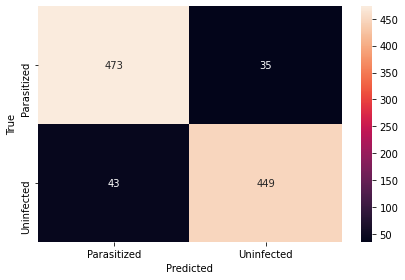

In [ ]:
x_axis_labels = ['Parasitized','Uninfected']
y_axis_labels = ['Parasitized','Uninfected']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Analisis Citra

### Based on Training Evaluate

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


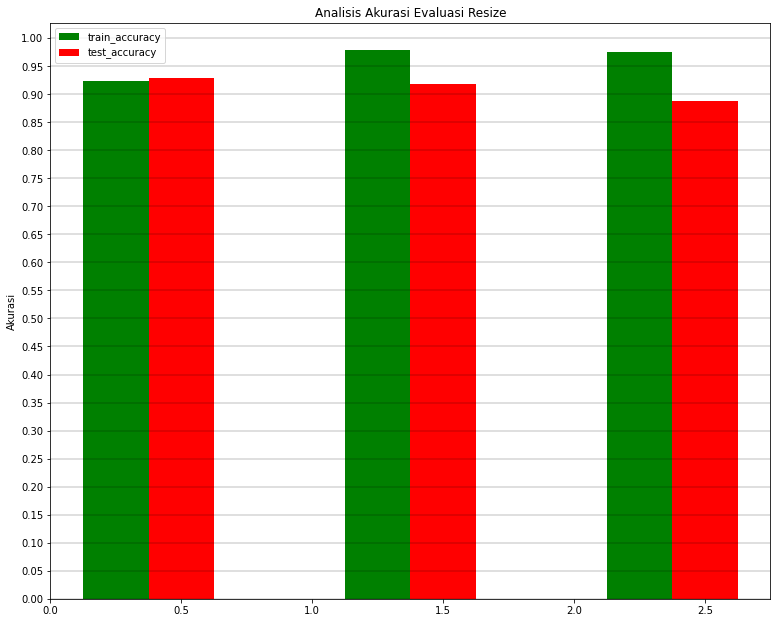

In [ ]:
ind = 0
width = 0.25

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind + 0.25, eval_acc_train[0], width, color='g')
ax.bar(ind + 0.5, eval_acc_test[0], width, color='r')
ax.bar(ind + 1.25, eval_acc_train[1], width, color='g')
ax.bar(ind + 1.5, eval_acc_test[1], width, color='r')
ax.bar(ind + 2.25, eval_acc_train[2], width, color='g')
ax.bar(ind + 2.5, eval_acc_test[2], width, color='r')

ax.set_ylabel('Akurasi')
ax.set_title('Analisis Akurasi Evaluasi Resize')
ax.set_yticks(np.arange(0, 1.05, 0.05))
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.25)
ax.legend(labels=['train_accuracy','test_accuracy'])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


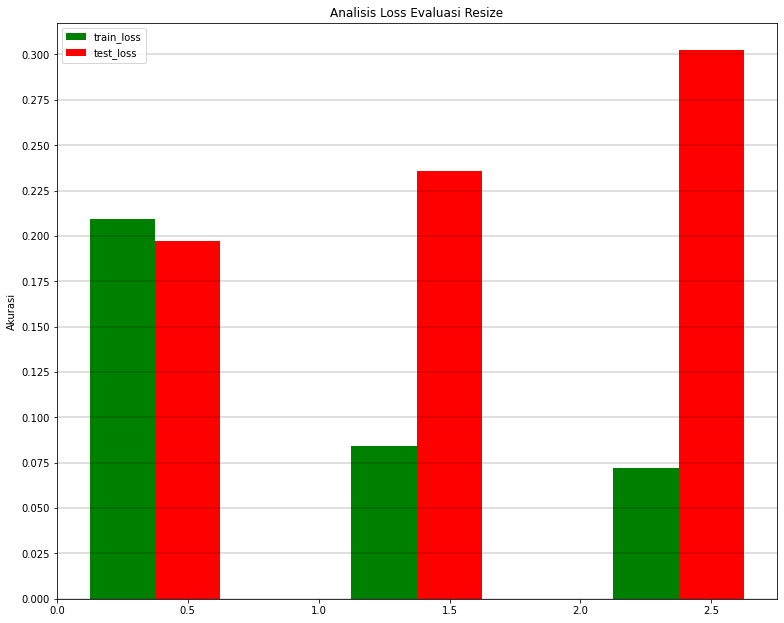

In [ ]:
ind = 0
width = 0.25

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind + 0.25, eval_loss_train[0], width, color='g')
ax.bar(ind + 0.5, eval_loss_test[0], width, color='r')
ax.bar(ind + 1.25, eval_loss_train[1], width, color='g')
ax.bar(ind + 1.5, eval_loss_test[1], width, color='r')
ax.bar(ind + 2.25, eval_loss_train[2], width, color='g')
ax.bar(ind + 2.5, eval_loss_test[2], width, color='r')

ax.set_ylabel('Akurasi')
ax.set_title('Analisis Loss Evaluasi Resize')
ax.set_yticks(np.arange(0, 0.325, 0.025))
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.25)
ax.legend(labels=['train_loss','test_loss'])

plt.tight_layout()
plt.show()

### Based on Predictions Accuracy

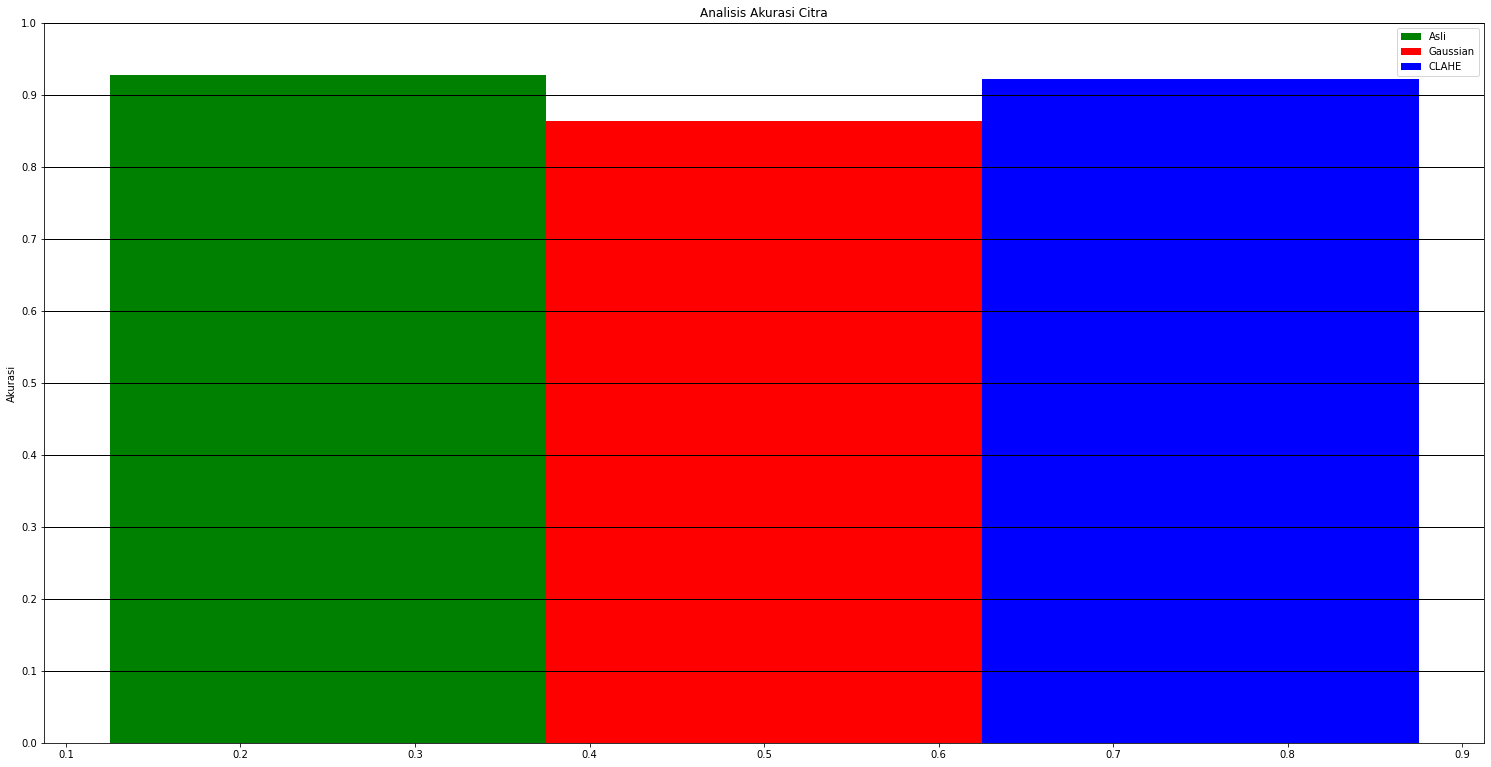

In [ ]:
ind = 0
width = 0.25
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind + 0.25, citra_acc[0], width, color='g')
ax.bar(ind + 0.5, citra_acc[1], width, color='r')
ax.bar(ind + 0.75, citra_acc[2], width, color='b')

ax.set_ylabel('Akurasi')
ax.set_title('Analisis Akurasi Citra')
ax.set_yticks(np.arange(0, 1.1, 0.1))
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 1)
ax.legend(labels=['Asli','Gaussian', 'CLAHE'])
plt.show()

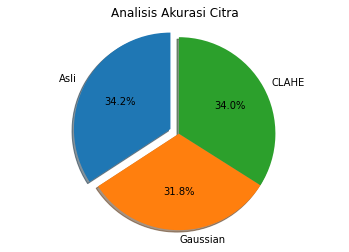

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
label = 'Asli','Gaussian', 'CLAHE'
sizes = citra_acc
explode = [0 if i != max(sizes) else 0.1 for i in sizes]

fig1, ax1 = plt.subplots()
plt.title('Analisis Akurasi Citra')
ax1.pie(sizes, explode=explode, labels=label, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
citra = [photos,Gaussian_photos,CLAHE_photos]
best_citra = citra[np.argmax(citra_acc)]
best_citra_name = label[np.argmax(citra_acc)]

In [ ]:
print('Best Citra : ',best_citra_name)

Best Citra :  Asli


# 3.**Optimizer**

In [ ]:
optimizer_acc = []
eval_acc_train,eval_loss_train = [],[]
eval_acc_test,eval_loss_test = [],[]

## Optimizer Adam
Resize 64, Citra Asli, LR = 0.001, BS = 16, Epochs = 10

In [ ]:
set_name = 'Resize '+best_resize_name+',Citra '+best_citra_name+',Optimizer Adam,LR 0.001,BS 16,Epochs 10'

In [ ]:
photos = best_citra

optimizer = 'Adam'
learning_rate = 0.001
batch_size = 16
epochs = 10
dropout = .0
dropout_end =.0

In [ ]:
model_params = dict(optimizer=optimizer,learning_rate=learning_rate,dropout=dropout,dropout_end=dropout_end)
model_params

{'dropout': 0.0,
 'dropout_end': 0.0,
 'learning_rate': 0.001,
 'optimizer': 'Adam'}

In [ ]:
fit_params = dict(epochs=epochs,batch_size=batch_size)
fit_params

{'batch_size': 16, 'epochs': 10}

Split Data Image into Train and Test Data

In [ ]:
# Split the test data and training data
(trainX, testX, trainY, testY) = train_test_split(photos.copy(), labels.copy(), test_size=0.25, random_state = 0)
print(trainX.shape)
print(testX.shape)

(3000, 64, 64, 3)
(1000, 64, 64, 3)


Normalize our Image matrix into [0 .. 1] range

In [ ]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Image Preview

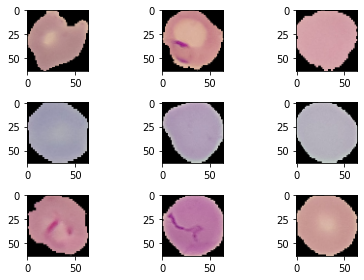

In [ ]:
# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[random.randint(0,trainX.shape[0])]);
# show the figure
plt.tight_layout()
plt.show()

### Training Data

In [ ]:
model = define_model(input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3]),**model_params)

In [ ]:
print('Load Model')
print('-------------------')
csv_logger = CSVLogger(folder + set_name + '.log', separator=',', append=False)
try:
  model = load_model(folder + set_name + '.h5')
  print('Success Load Model')
  print('-------------------')
except:
  print('Model not found in directory\nCreating new Model')
  print('-------------------')
  model.fit(trainX, trainY, validation_data=(testX, testY),callbacks=[csv_logger], **fit_params)
  model.save(folder + set_name + '.h5')
  print('Model Created and Saved')
  print('-------------------')

Load Model
-------------------
Success Load Model
-------------------


### Plot diagnostic learning curves

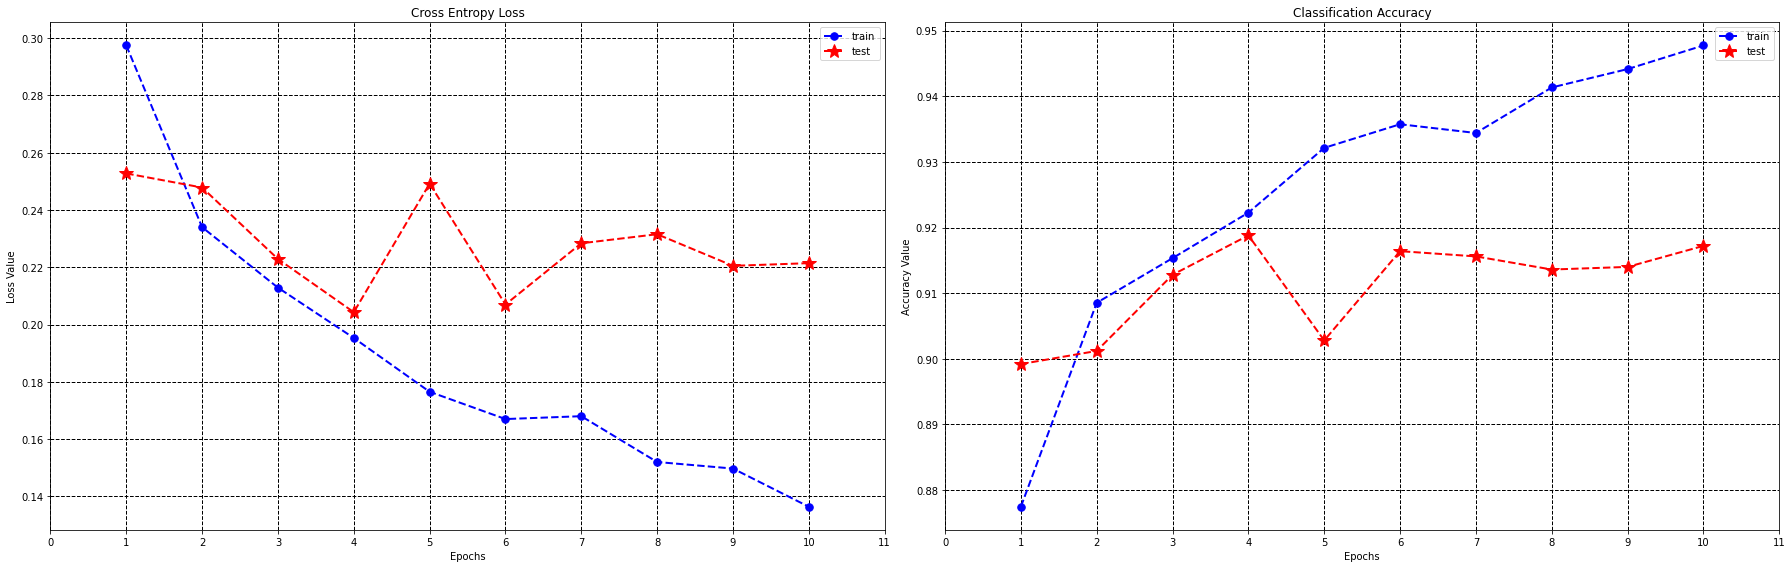

In [ ]:
log_data = pd.read_csv(folder + set_name + '.log', sep=',', engine='python')
summarize_diagnostics(log_data)

In [ ]:
#ini buat training :
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=1)
eval_acc_train.append(train_accuracy)
eval_loss_train.append(train_loss)

#ini buat testing :
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=1)
eval_acc_test.append(test_accuracy)
eval_loss_test.append(test_loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 34s 1s/step - loss: 0.1974 - accuracy: 0.9280


### Prediction

In [ ]:
predictions = model.predict(testX, fit_params['batch_size'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Rescale output Prediction into 0.0 or 1.0 value

In [ ]:
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

(1000, 1)

Reshape TestY

In [ ]:
testY = testY.reshape(testY.shape[0],1)

### Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[474,  34],
       [ 38, 454]])

### Classification Report

In [ ]:
target_names=['Parasitized','Uninfected']

print(classification_report(testY,predictions,target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.93      0.93      0.93       508
  Uninfected       0.93      0.92      0.93       492

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
optimizer_acc.append(acc)
print('Accuracy : %.5f' % acc)

Accuracy : 0.92800


### Heatmap

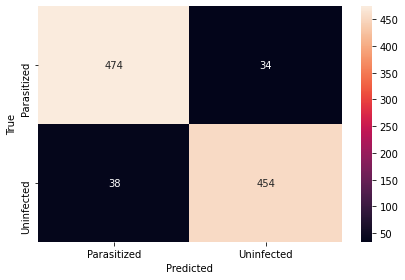

In [ ]:
x_axis_labels = ['Parasitized','Uninfected']
y_axis_labels = ['Parasitized','Uninfected']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Optimizer SGD
Resize 64, Citra Asli, LR = 0.001, BS = 16, Epochs = 10

In [ ]:
set_name = 'Resize '+best_resize_name+',Citra '+best_citra_name+',Optimizer SGD,LR 0.001,BS 16,Epochs 10'

In [ ]:
photos = best_citra

optimizer = 'SGD'
learning_rate = 0.001
batch_size = 16
epochs = 10
dropout = .0
dropout_end =.0

In [ ]:
model_params = dict(optimizer=optimizer,learning_rate=learning_rate,dropout=dropout,dropout_end=dropout_end)
model_params

{'dropout': 0.0,
 'dropout_end': 0.0,
 'learning_rate': 0.001,
 'optimizer': 'SGD'}

In [ ]:
fit_params = dict(epochs=epochs,batch_size=batch_size)
fit_params

{'batch_size': 16, 'epochs': 10}

Split Data Image into Train and Test Data

In [ ]:
# Split the test data and training data
(trainX, testX, trainY, testY) = train_test_split(photos.copy(), labels.copy(), test_size=0.25, random_state = 0)
print(trainX.shape)
print(testX.shape)

(3000, 64, 64, 3)
(1000, 64, 64, 3)


Normalize our Image matrix into [0 .. 1] range

In [ ]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Image Preview

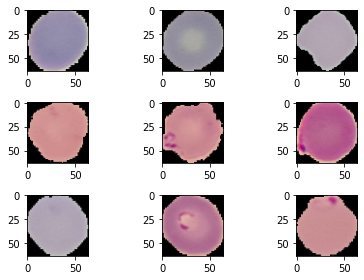

In [ ]:
# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[random.randint(0,trainX.shape[0])]);
# show the figure
plt.tight_layout()
plt.show()

### Training Data

In [ ]:
model = define_model(input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3]),**model_params)

In [ ]:
print('Load Model')
print('-------------------')
csv_logger = CSVLogger(folder + set_name + '.log', separator=',', append=False)
try:
  model = load_model(folder + set_name + '.h5')
  print('Success Load Model')
  print('-------------------')
except:
  print('Model not found in directory\nCreating new Model')
  print('-------------------')
  model.fit(trainX, trainY, validation_data=(testX, testY),callbacks=[csv_logger], **fit_params)
  model.save(folder + set_name + '.h5')
  print('Model Created and Saved')
  print('-------------------')

Load Model
-------------------
Success Load Model
-------------------


### Plot diagnostic learning curves

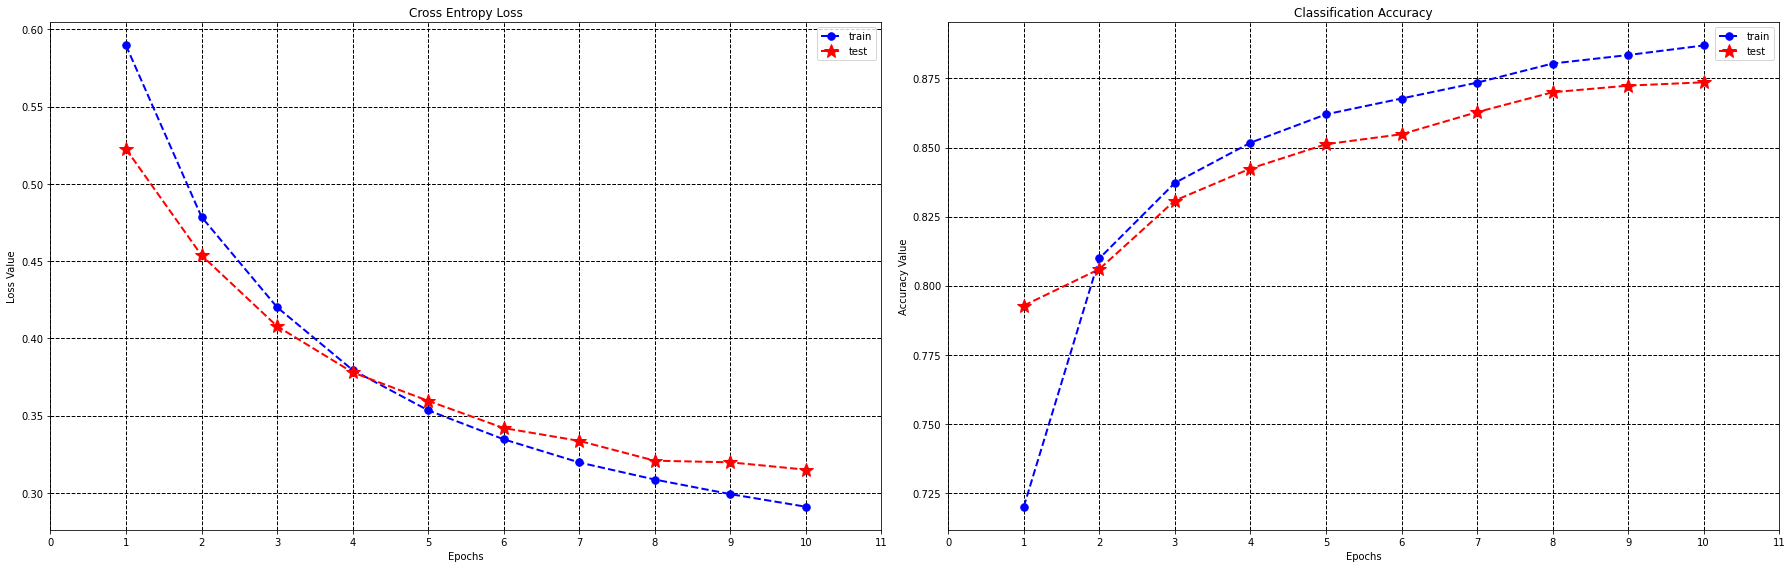

In [ ]:
log_data = pd.read_csv(folder + set_name + '.log', sep=',', engine='python')
summarize_diagnostics(log_data)

In [ ]:
#ini buat training :
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=1)
eval_acc_train.append(train_accuracy)
eval_loss_train.append(train_loss)

#ini buat testing :
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=1)
eval_acc_test.append(test_accuracy)
eval_loss_test.append(test_loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 34s 1s/step - loss: 0.1974 - accuracy: 0.9280


### Prediction

In [ ]:
predictions = model.predict(testX, fit_params['batch_size'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Rescale output Prediction into 0.0 or 1.0 value

In [ ]:
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

(1000, 1)

Reshape TestY

In [ ]:
testY = testY.reshape(testY.shape[0],1)

### Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[448,  60],
       [ 92, 400]])

### Classification Report

In [ ]:
target_names=['Parasitized','Uninfected']

print(classification_report(testY,predictions,target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.83      0.88      0.85       508
  Uninfected       0.87      0.81      0.84       492

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
optimizer_acc.append(acc)
print('Accuracy : %.5f' % acc)

Accuracy : 0.84800


### Heatmap

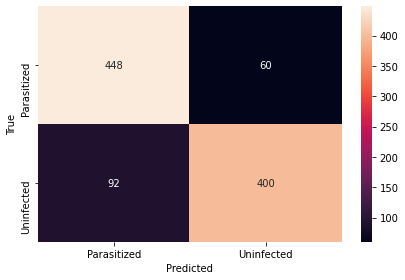

In [ ]:
x_axis_labels = ['Parasitized','Uninfected']
y_axis_labels = ['Parasitized','Uninfected']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Optimizer RMSprop
Resize 64, Citra Asli, LR = 0.001, BS = 16, Epochs = 10

In [ ]:
set_name = 'Resize '+best_resize_name+',Citra '+best_citra_name+',Optimizer RMSprop,LR 0.001,BS 16,Epochs 10'

In [ ]:
photos = best_citra

optimizer = 'RMSprop'
learning_rate = 0.001
batch_size = 16
epochs = 10
dropout = .0
dropout_end =.0

In [ ]:
model_params = dict(optimizer=optimizer,learning_rate=learning_rate,dropout=dropout,dropout_end=dropout_end)
model_params

{'dropout': 0.0,
 'dropout_end': 0.0,
 'learning_rate': 0.001,
 'optimizer': 'RMSprop'}

In [ ]:
fit_params = dict(epochs=epochs,batch_size=batch_size)
fit_params

{'batch_size': 16, 'epochs': 10}

Split Data Image into Train and Test Data

In [ ]:
# Split the test data and training data
(trainX, testX, trainY, testY) = train_test_split(photos.copy(), labels.copy(), test_size=0.25, random_state = 0)
print(trainX.shape)
print(testX.shape)

(3000, 64, 64, 3)
(1000, 64, 64, 3)


Normalize our Image matrix into [0 .. 1] range

In [ ]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Image Preview

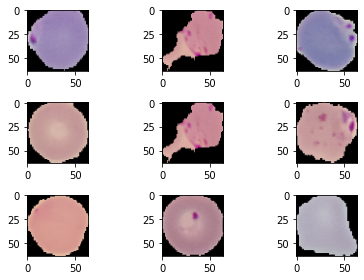

In [ ]:
# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[random.randint(0,trainX.shape[0])]);
# show the figure
plt.tight_layout()
plt.show()

### Training Data

In [ ]:
model = define_model(input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3]),**model_params)

In [ ]:
print('Load Model')
print('-------------------')
csv_logger = CSVLogger(folder + set_name + '.log', separator=',', append=False)
try:
  model = load_model(folder + set_name + '.h5')
  print('Success Load Model')
  print('-------------------')
except:
  print('Model not found in directory\nCreating new Model')
  print('-------------------')
  model.fit(trainX, trainY, validation_data=(testX, testY),callbacks=[csv_logger], **fit_params)
  model.save(folder + set_name + '.h5')
  print('Model Created and Saved')
  print('-------------------')

Load Model
-------------------
Success Load Model
-------------------


### Plot diagnostic learning curves

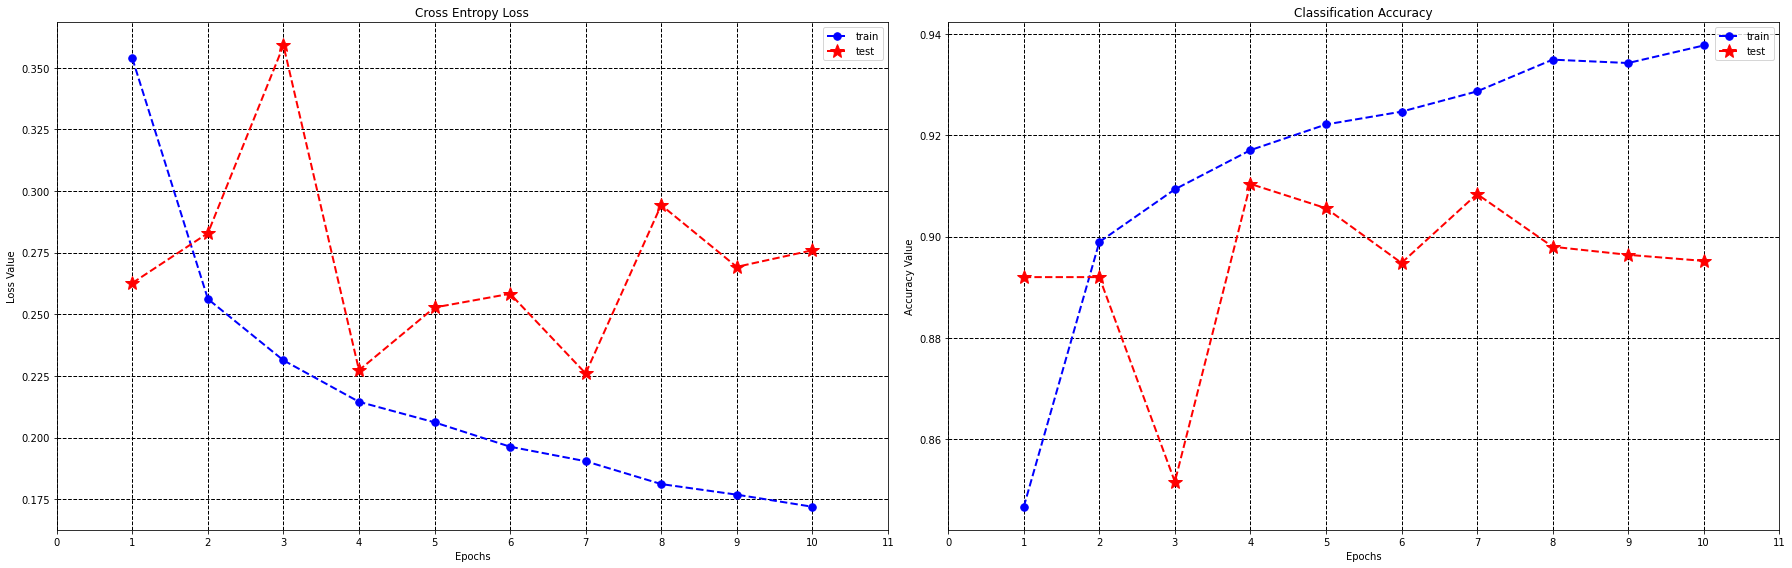

In [ ]:
log_data = pd.read_csv(folder + set_name + '.log', sep=',', engine='python')
summarize_diagnostics(log_data)

In [ ]:
#ini buat training :
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=1)
eval_acc_train.append(train_accuracy)
eval_loss_train.append(train_loss)

#ini buat testing :
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=1)
eval_acc_test.append(test_accuracy)
eval_loss_test.append(test_loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 34s 1s/step - loss: 0.1974 - accuracy: 0.9280


### Prediction

In [ ]:
predictions = model.predict(testX, fit_params['batch_size'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Rescale output Prediction into 0.0 or 1.0 value

In [ ]:
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

(1000, 1)

Reshape TestY

In [ ]:
testY = testY.reshape(testY.shape[0],1)

### Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[392, 116],
       [ 18, 474]])

### Classification Report

In [ ]:
target_names=['Parasitized','Uninfected']

print(classification_report(testY,predictions,target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.96      0.77      0.85       508
  Uninfected       0.80      0.96      0.88       492

    accuracy                           0.87      1000
   macro avg       0.88      0.87      0.87      1000
weighted avg       0.88      0.87      0.86      1000



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
optimizer_acc.append(acc)
print('Accuracy : %.5f' % acc)

Accuracy : 0.86600


### Heatmap

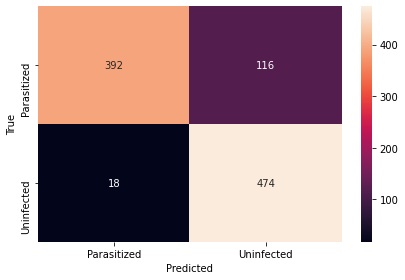

In [ ]:
x_axis_labels = ['Parasitized','Uninfected']
y_axis_labels = ['Parasitized','Uninfected']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Analisis Optimizer

### Based on Training Evaluate

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


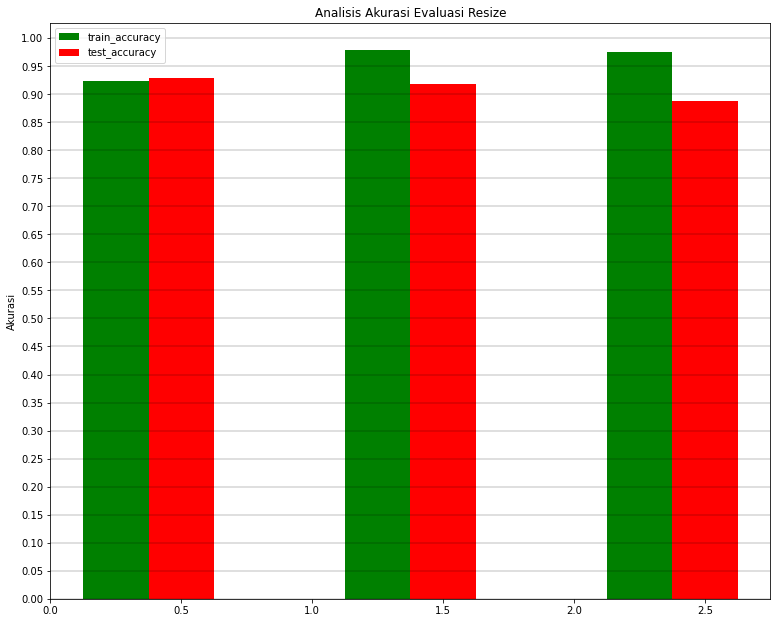

In [ ]:
ind = 0
width = 0.25

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind + 0.25, eval_acc_train[0], width, color='g')
ax.bar(ind + 0.5, eval_acc_test[0], width, color='r')
ax.bar(ind + 1.25, eval_acc_train[1], width, color='g')
ax.bar(ind + 1.5, eval_acc_test[1], width, color='r')
ax.bar(ind + 2.25, eval_acc_train[2], width, color='g')
ax.bar(ind + 2.5, eval_acc_test[2], width, color='r')

ax.set_ylabel('Akurasi')
ax.set_title('Analisis Akurasi Evaluasi Resize')
ax.set_yticks(np.arange(0, 1.05, 0.05))
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.25)
ax.legend(labels=['train_accuracy','test_accuracy'])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


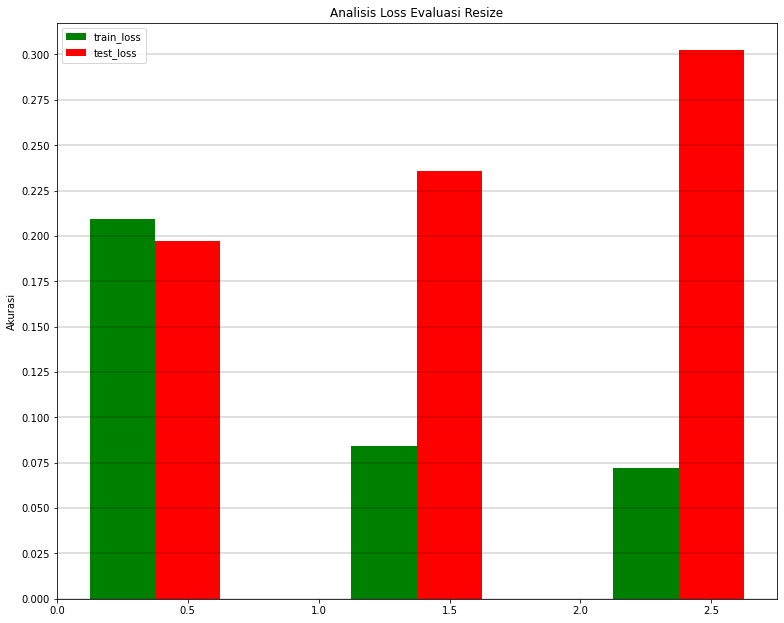

In [ ]:
ind = 0
width = 0.25

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind + 0.25, eval_loss_train[0], width, color='g')
ax.bar(ind + 0.5, eval_loss_test[0], width, color='r')
ax.bar(ind + 1.25, eval_loss_train[1], width, color='g')
ax.bar(ind + 1.5, eval_loss_test[1], width, color='r')
ax.bar(ind + 2.25, eval_loss_train[2], width, color='g')
ax.bar(ind + 2.5, eval_loss_test[2], width, color='r')

ax.set_ylabel('Akurasi')
ax.set_title('Analisis Loss Evaluasi Resize')
ax.set_yticks(np.arange(0, 0.325, 0.025))
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.25)
ax.legend(labels=['train_loss','test_loss'])

plt.tight_layout()
plt.show()

### Based on Predictions Accuracy

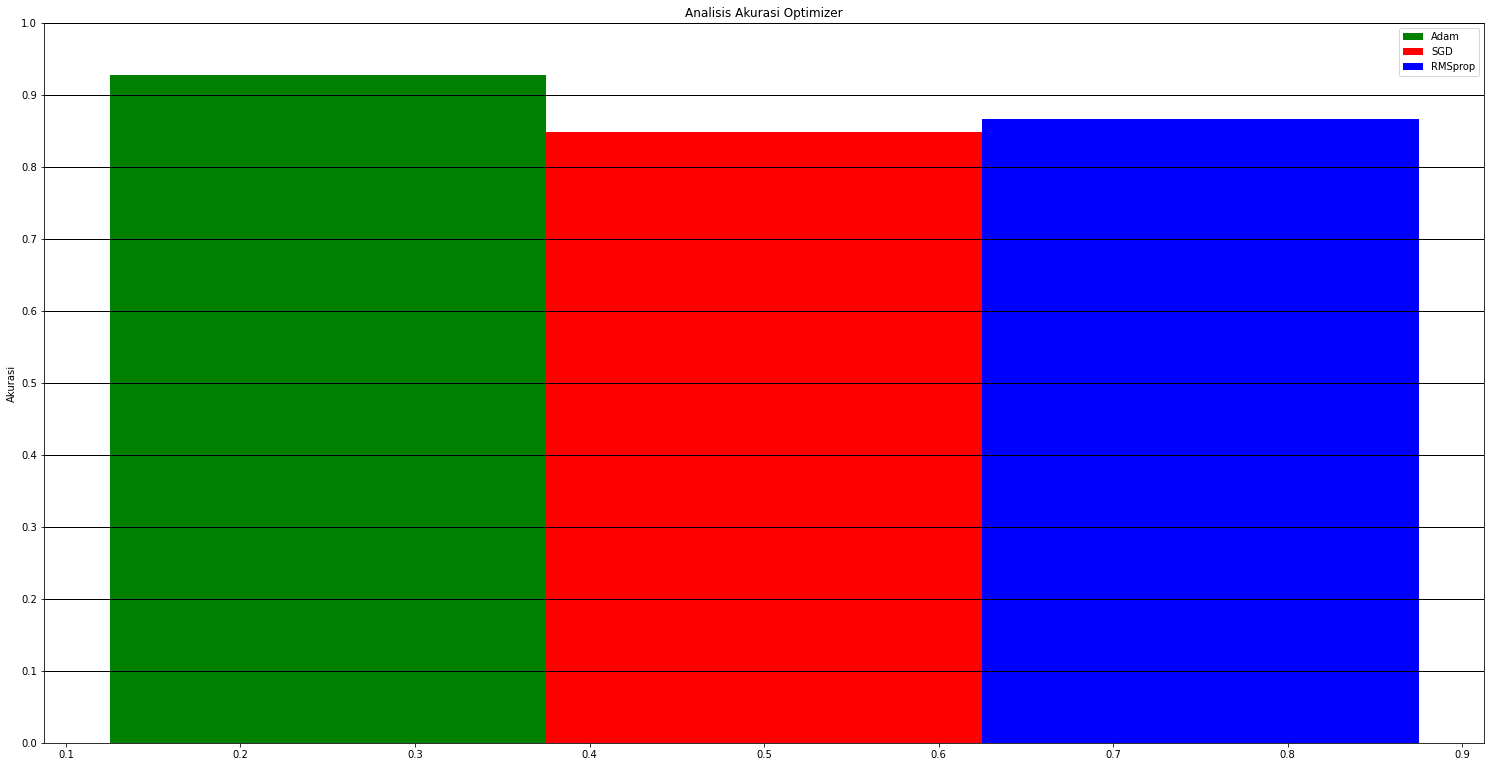

In [ ]:
ind = 0
width = 0.25
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind + 0.25, optimizer_acc[0], width, color='g')
ax.bar(ind + 0.5, optimizer_acc[1], width, color='r')
ax.bar(ind + 0.75, optimizer_acc[2], width, color='b')

ax.set_ylabel('Akurasi')
ax.set_title('Analisis Akurasi Optimizer')
ax.set_yticks(np.arange(0, 1.1, 0.1))
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 1)
ax.legend(labels=['Adam','SGD', 'RMSprop'])
plt.show()

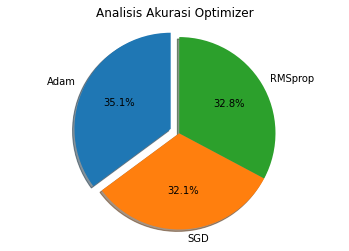

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
label = 'Adam','SGD', 'RMSprop'
sizes = optimizer_acc
explode = [0 if i != max(sizes) else 0.1 for i in sizes]

fig1, ax1 = plt.subplots()
plt.title('Analisis Akurasi Optimizer')
ax1.pie(sizes, explode=explode, labels=label, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
optimize = ['Adam','SGD', 'RMSprop']
best_optimizer = optimize[np.argmax(optimizer_acc)]

In [ ]:
print('Best Optimizer : ',best_optimizer)

Best Optimizer :  Adam


# 4.**Learning_Rate**

In [ ]:
LR_acc = []
eval_acc_train,eval_loss_train = [],[]
eval_acc_test,eval_loss_test = [],[]

## Learning Rate 0.01
Resize 64, Citra Asli, Optimizer RMSprop, BS = 16, Epochs = 10

In [ ]:
set_name = 'Resize '+best_resize_name+',Citra '+best_citra_name+',Optimizer '+best_optimizer+',LR 0.01,BS 16,Epochs 10'

In [ ]:
photos = best_citra

optimizer = best_optimizer
learning_rate = 0.01
batch_size = 16
epochs = 10
dropout = .0
dropout_end =.0

In [ ]:
model_params = dict(optimizer=optimizer,learning_rate=learning_rate,dropout=dropout,dropout_end=dropout_end)
model_params

{'dropout': 0.0,
 'dropout_end': 0.0,
 'learning_rate': 0.01,
 'optimizer': 'Adam'}

In [ ]:
fit_params = dict(epochs=epochs,batch_size=batch_size)
fit_params

{'batch_size': 16, 'epochs': 10}

Split Data Image into Train and Test Data

In [ ]:
# Split the test data and training data
(trainX, testX, trainY, testY) = train_test_split(photos.copy(), labels.copy(), test_size=0.25, random_state = 0)
print(trainX.shape)
print(testX.shape)

(3000, 64, 64, 3)
(1000, 64, 64, 3)


Normalize our Image matrix into [0 .. 1] range

In [ ]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Image Preview

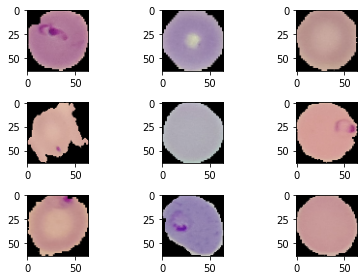

In [ ]:
# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[random.randint(0,trainX.shape[0])]);
# show the figure
plt.tight_layout()
plt.show()

### Training Data

In [ ]:
model = define_model(input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3]),**model_params)

In [ ]:
print('Load Model')
print('-------------------')
csv_logger = CSVLogger(folder + set_name + '.log', separator=',', append=False)
try:
  model = load_model(folder + set_name + '.h5')
  print('Success Load Model')
  print('-------------------')
except:
  print('Model not found in directory\nCreating new Model')
  print('-------------------')
  model.fit(trainX, trainY, validation_data=(testX, testY),callbacks=[csv_logger], **fit_params)
  model.save(folder + set_name + '.h5')
  print('Model Created and Saved')
  print('-------------------')

Load Model
-------------------
Success Load Model
-------------------


### Plot diagnostic learning curves

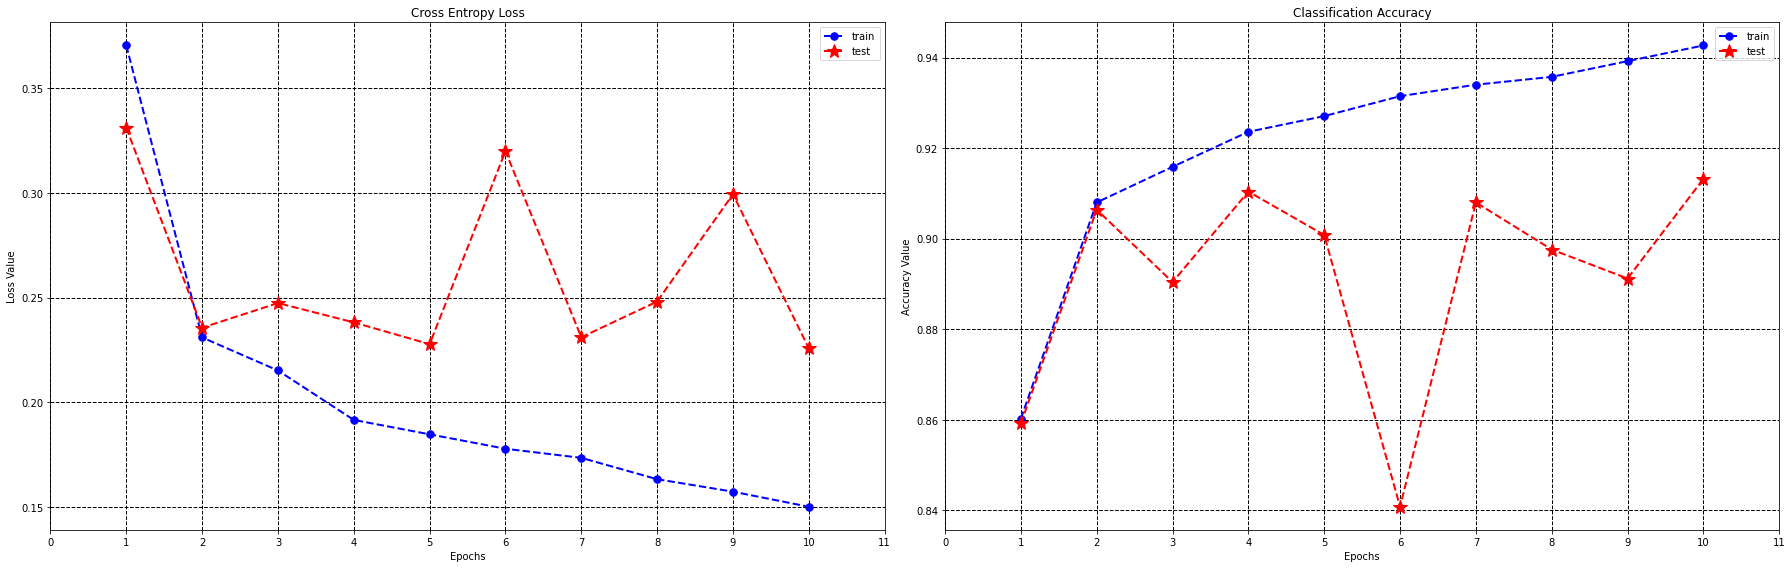

In [ ]:
log_data = pd.read_csv(folder + set_name + '.log', sep=',', engine='python')
summarize_diagnostics(log_data)

In [ ]:
#ini buat training :
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=1)
eval_acc_train.append(train_accuracy)
eval_loss_train.append(train_loss)

#ini buat testing :
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=1)
eval_acc_test.append(test_accuracy)
eval_loss_test.append(test_loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 34s 1s/step - loss: 0.1974 - accuracy: 0.9280


### Prediction

In [ ]:
predictions = model.predict(testX, fit_params['batch_size'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Rescale output Prediction into 0.0 or 1.0 value

In [ ]:
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

(1000, 1)

Reshape TestY

In [ ]:
testY = testY.reshape(testY.shape[0],1)

### Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[437,  71],
       [ 28, 464]])

### Classification Report

In [ ]:
target_names=['Parasitized','Uninfected']

print(classification_report(testY,predictions,target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.94      0.86      0.90       508
  Uninfected       0.87      0.94      0.90       492

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
LR_acc.append(acc)
print('Accuracy : %.5f' % acc)

Accuracy : 0.90100


### Heatmap

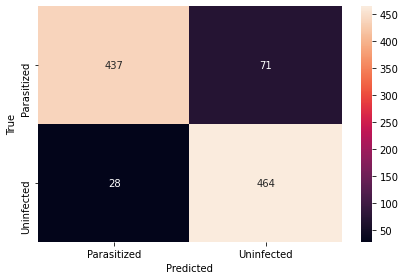

In [ ]:
x_axis_labels = ['Parasitized','Uninfected']
y_axis_labels = ['Parasitized','Uninfected']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Learning Rate 0.001
Resize 64, Citra Asli, Optimizer RMSprop, BS = 16, Epochs = 10

In [ ]:
set_name = 'Resize '+best_resize_name+',Citra '+best_citra_name+',Optimizer '+best_optimizer+',LR 0.001,BS 16,Epochs 10'

In [ ]:
photos = best_citra

optimizer = best_optimizer
learning_rate = 0.001
batch_size = 16
epochs = 10
dropout = .0
dropout_end =.0

In [ ]:
model_params = dict(optimizer=optimizer,learning_rate=learning_rate,dropout=dropout,dropout_end=dropout_end)
model_params

{'dropout': 0.0,
 'dropout_end': 0.0,
 'learning_rate': 0.001,
 'optimizer': 'Adam'}

In [ ]:
fit_params = dict(epochs=epochs,batch_size=batch_size)
fit_params

{'batch_size': 16, 'epochs': 10}

Split Data Image into Train and Test Data

In [ ]:
# Split the test data and training data
(trainX, testX, trainY, testY) = train_test_split(photos.copy(), labels.copy(), test_size=0.25, random_state = 0)
print(trainX.shape)
print(testX.shape)

(3000, 64, 64, 3)
(1000, 64, 64, 3)


Normalize our Image matrix into [0 .. 1] range

In [ ]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Image Preview

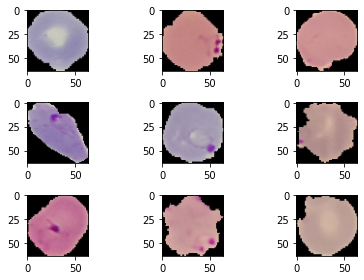

In [ ]:
# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[random.randint(0,trainX.shape[0])]);
# show the figure
plt.tight_layout()
plt.show()

### Training Data

In [ ]:
model = define_model(input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3]),**model_params)

In [ ]:
print('Load Model')
print('-------------------')
csv_logger = CSVLogger(folder + set_name + '.log', separator=',', append=False)
try:
  model = load_model(folder + set_name + '.h5')
  print('Success Load Model')
  print('-------------------')
except:
  print('Model not found in directory\nCreating new Model')
  print('-------------------')
  model.fit(trainX, trainY, validation_data=(testX, testY),callbacks=[csv_logger], **fit_params)
  model.save(folder + set_name + '.h5')
  print('Model Created and Saved')
  print('-------------------')

Load Model
-------------------
Success Load Model
-------------------


### Plot diagnostic learning curves

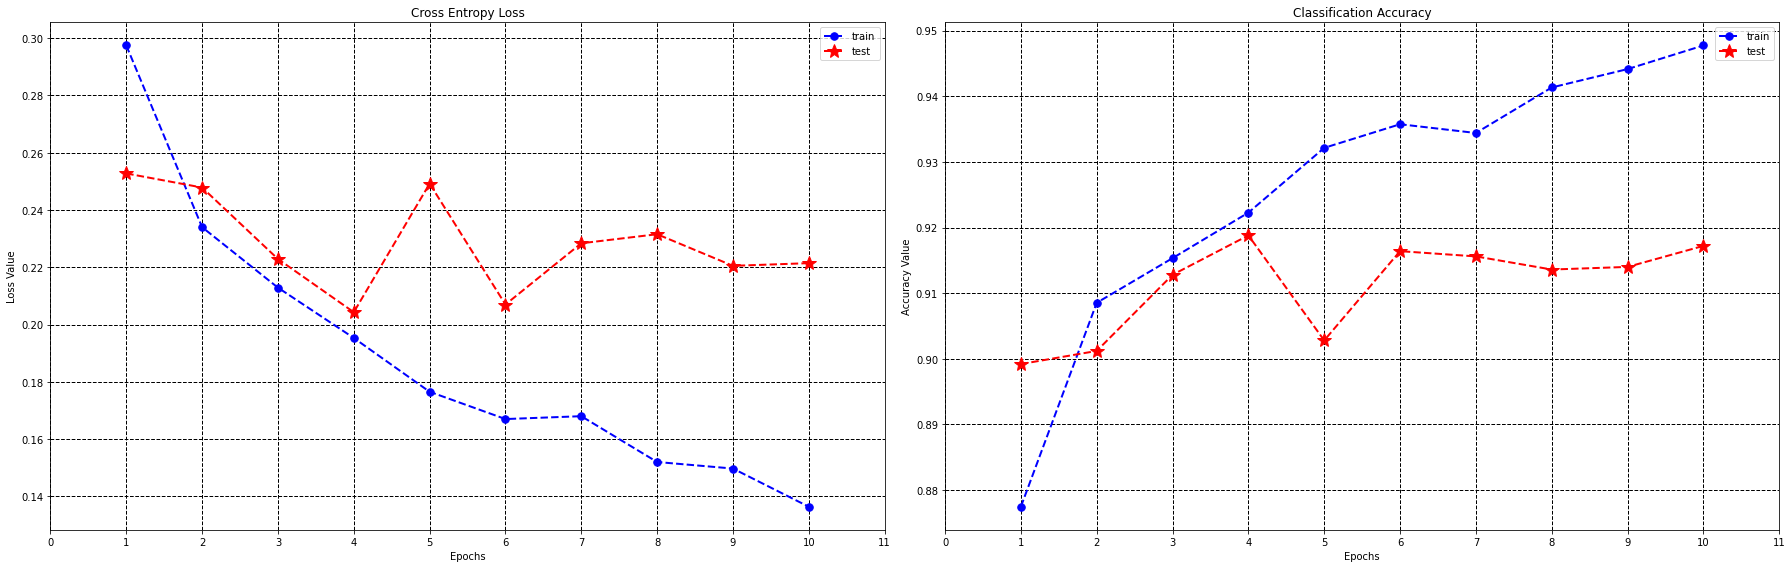

In [ ]:
log_data = pd.read_csv(folder + set_name + '.log', sep=',', engine='python')
summarize_diagnostics(log_data)

In [ ]:
#ini buat training :
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=1)
eval_acc_train.append(train_accuracy)
eval_loss_train.append(train_loss)

#ini buat testing :
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=1)
eval_acc_test.append(test_accuracy)
eval_loss_test.append(test_loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 34s 1s/step - loss: 0.1974 - accuracy: 0.9280


### Prediction

In [ ]:
predictions = model.predict(testX, fit_params['batch_size'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Rescale output Prediction into 0.0 or 1.0 value

In [ ]:
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

(1000, 1)

Reshape TestY

In [ ]:
testY = testY.reshape(testY.shape[0],1)

### Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[474,  34],
       [ 38, 454]])

### Classification Report

In [ ]:
target_names=['Parasitized','Uninfected']

print(classification_report(testY,predictions,target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.93      0.93      0.93       508
  Uninfected       0.93      0.92      0.93       492

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
LR_acc.append(acc)
print('Accuracy : %.5f' % acc)

Accuracy : 0.92800


### Heatmap

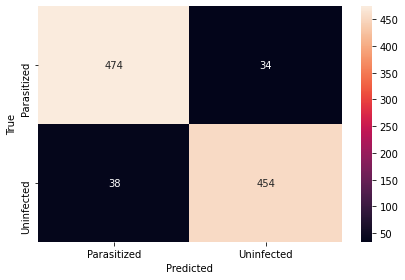

In [ ]:
x_axis_labels = ['Parasitized','Uninfected']
y_axis_labels = ['Parasitized','Uninfected']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Learning Rate 0.0001
Resize 64, Citra Asli, Optimizer RMSprop, BS = 16, Epochs = 10

In [ ]:
set_name = 'Resize '+best_resize_name+',Citra '+best_citra_name+',Optimizer '+best_optimizer+',LR 0.0001,BS 16,Epochs 10'

In [ ]:
photos = best_citra

optimizer = best_optimizer
learning_rate = 0.0001
batch_size = 16
epochs = 10
dropout = .0
dropout_end =.0

In [ ]:
model_params = dict(optimizer=optimizer,learning_rate=learning_rate,dropout=dropout,dropout_end=dropout_end)
model_params

{'dropout': 0.0,
 'dropout_end': 0.0,
 'learning_rate': 0.0001,
 'optimizer': 'Adam'}

In [ ]:
fit_params = dict(epochs=epochs,batch_size=batch_size)
fit_params

{'batch_size': 16, 'epochs': 10}

Split Data Image into Train and Test Data

In [ ]:
# Split the test data and training data
(trainX, testX, trainY, testY) = train_test_split(photos.copy(), labels.copy(), test_size=0.25, random_state = 0)
print(trainX.shape)
print(testX.shape)

(3000, 64, 64, 3)
(1000, 64, 64, 3)


Normalize our Image matrix into [0 .. 1] range

In [ ]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Image Preview

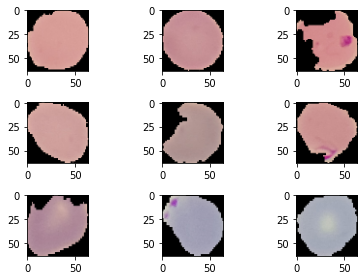

In [ ]:
# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[random.randint(0,trainX.shape[0])]);
# show the figure
plt.tight_layout()
plt.show()

### Training Data

In [ ]:
model = define_model(input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3]),**model_params)

In [ ]:
print('Load Model')
print('-------------------')
csv_logger = CSVLogger(folder + set_name + '.log', separator=',', append=False)
try:
  model = load_model(folder + set_name + '.h5')
  print('Success Load Model')
  print('-------------------')
except:
  print('Model not found in directory\nCreating new Model')
  print('-------------------')
  model.fit(trainX, trainY, validation_data=(testX, testY),callbacks=[csv_logger], **fit_params)
  model.save(folder + set_name + '.h5')
  print('Model Created and Saved')
  print('-------------------')

Load Model
-------------------
Success Load Model
-------------------


### Plot diagnostic learning curves

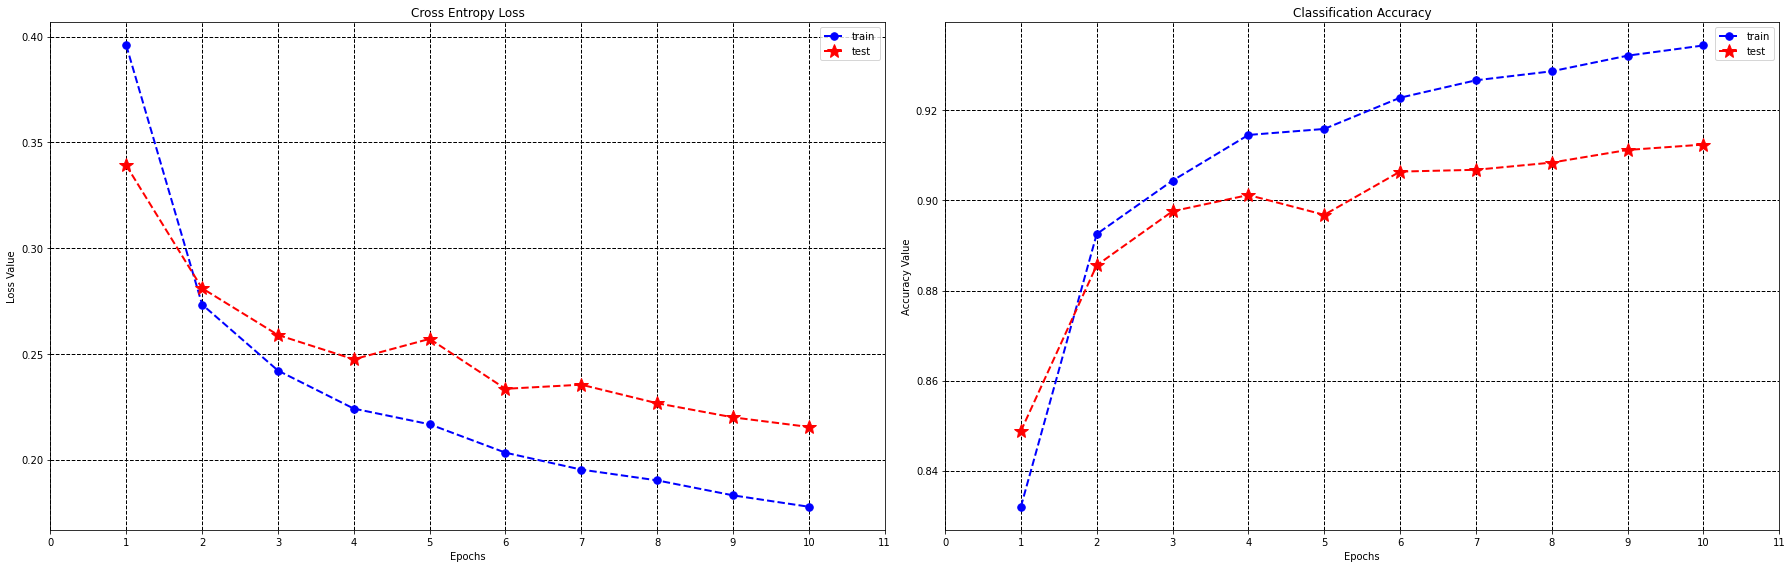

In [ ]:
log_data = pd.read_csv(folder + set_name + '.log', sep=',', engine='python')
summarize_diagnostics(log_data)

In [ ]:
#ini buat training :
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=1)
eval_acc_train.append(train_accuracy)
eval_loss_train.append(train_loss)

#ini buat testing :
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=1)
eval_acc_test.append(test_accuracy)
eval_loss_test.append(test_loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 34s 1s/step - loss: 0.1974 - accuracy: 0.9280


### Prediction

In [ ]:
predictions = model.predict(testX, fit_params['batch_size'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Rescale output Prediction into 0.0 or 1.0 value

In [ ]:
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

(1000, 1)

Reshape TestY

In [ ]:
testY = testY.reshape(testY.shape[0],1)

### Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[440,  68],
       [ 33, 459]])

### Classification Report

In [ ]:
target_names=['Parasitized','Uninfected']

print(classification_report(testY,predictions,target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.93      0.87      0.90       508
  Uninfected       0.87      0.93      0.90       492

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
LR_acc.append(acc)
print('Accuracy : %.5f' % acc)

Accuracy : 0.89900


### Heatmap

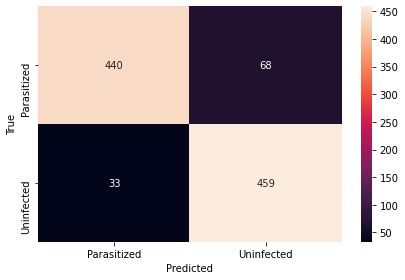

In [ ]:
x_axis_labels = ['Parasitized','Uninfected']
y_axis_labels = ['Parasitized','Uninfected']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Analisis Learning_rate

### Based on Training Evaluate

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


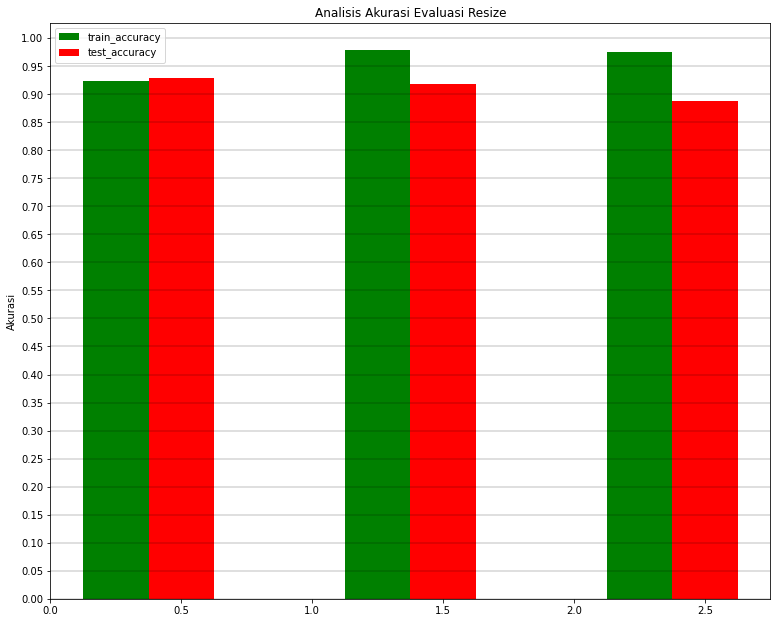

In [ ]:
ind = 0
width = 0.25

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind + 0.25, eval_acc_train[0], width, color='g')
ax.bar(ind + 0.5, eval_acc_test[0], width, color='r')
ax.bar(ind + 1.25, eval_acc_train[1], width, color='g')
ax.bar(ind + 1.5, eval_acc_test[1], width, color='r')
ax.bar(ind + 2.25, eval_acc_train[2], width, color='g')
ax.bar(ind + 2.5, eval_acc_test[2], width, color='r')

ax.set_ylabel('Akurasi')
ax.set_title('Analisis Akurasi Evaluasi Resize')
ax.set_yticks(np.arange(0, 1.05, 0.05))
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.25)
ax.legend(labels=['train_accuracy','test_accuracy'])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


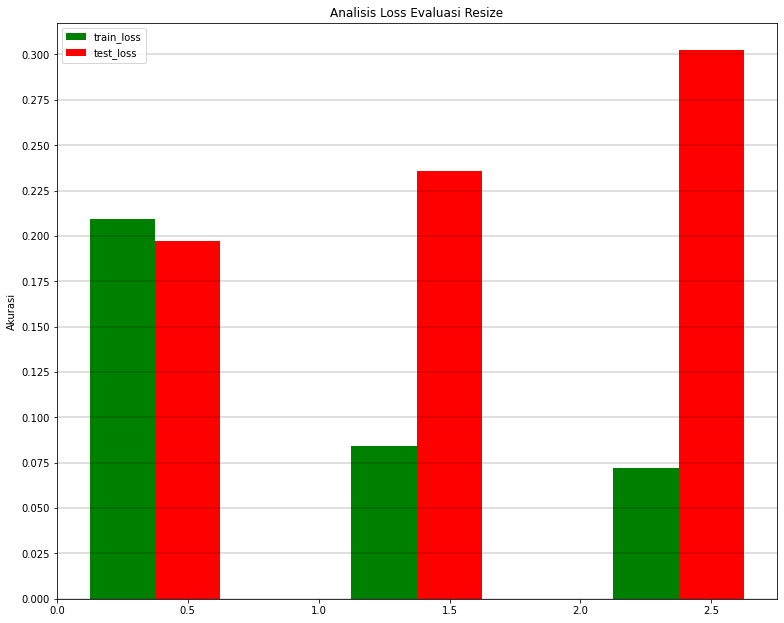

In [ ]:
ind = 0
width = 0.25

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind + 0.25, eval_loss_train[0], width, color='g')
ax.bar(ind + 0.5, eval_loss_test[0], width, color='r')
ax.bar(ind + 1.25, eval_loss_train[1], width, color='g')
ax.bar(ind + 1.5, eval_loss_test[1], width, color='r')
ax.bar(ind + 2.25, eval_loss_train[2], width, color='g')
ax.bar(ind + 2.5, eval_loss_test[2], width, color='r')

ax.set_ylabel('Akurasi')
ax.set_title('Analisis Loss Evaluasi Resize')
ax.set_yticks(np.arange(0, 0.325, 0.025))
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.25)
ax.legend(labels=['train_loss','test_loss'])

plt.tight_layout()
plt.show()

### Based on Predictions Accuracy

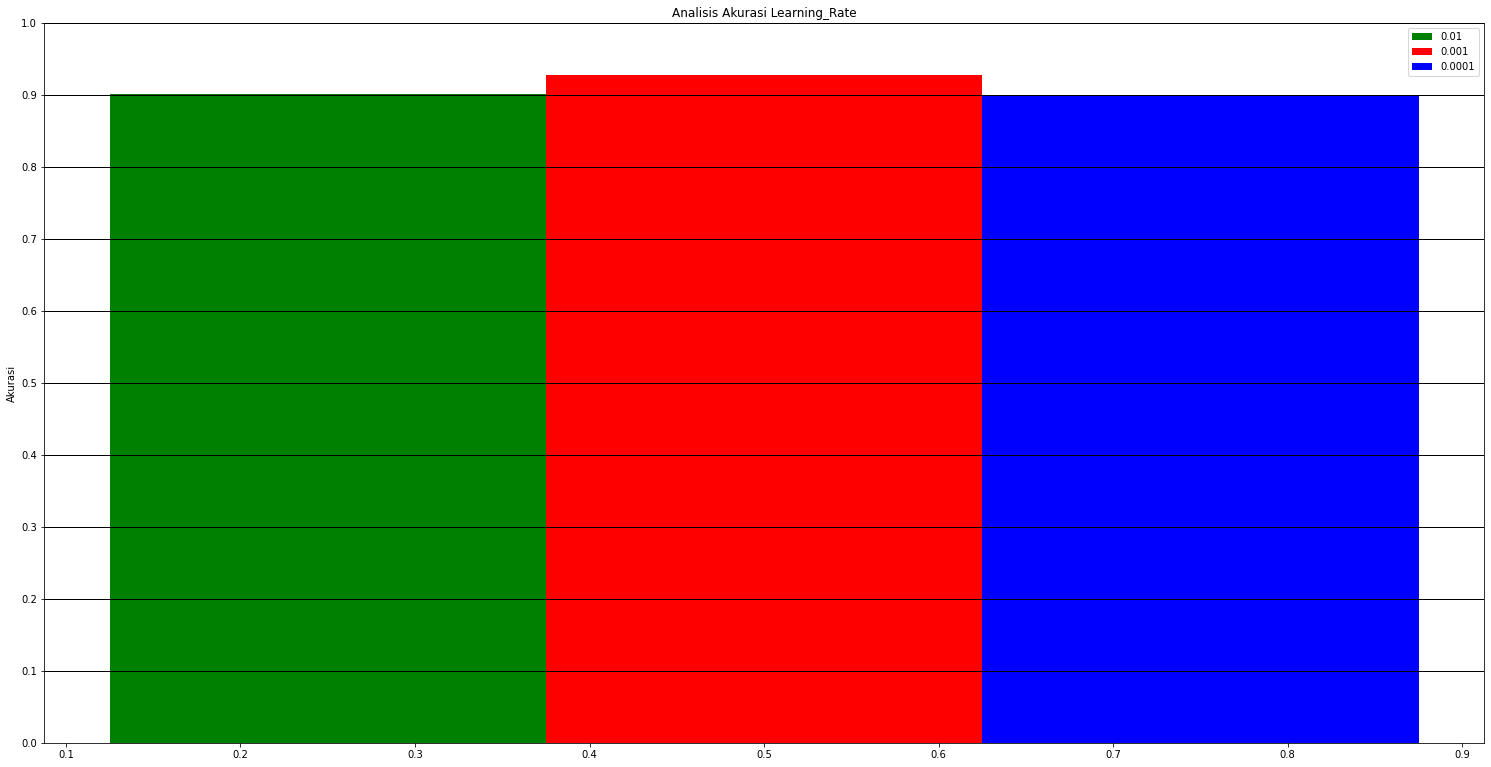

In [ ]:
ind = 0
width = 0.25
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind + 0.25, LR_acc[0], width, color='g')
ax.bar(ind + 0.5, LR_acc[1], width, color='r')
ax.bar(ind + 0.75, LR_acc[2], width, color='b')

ax.set_ylabel('Akurasi')
ax.set_title('Analisis Akurasi Learning_Rate')
ax.set_yticks(np.arange(0, 1.1, 0.1))
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 1)
ax.legend(labels=['0.01','0.001', '0.0001'])
plt.show()

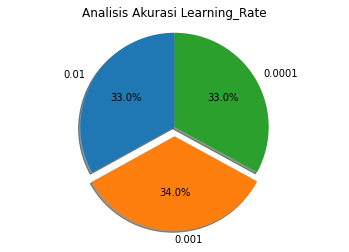

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
label = '0.01','0.001', '0.0001'
sizes = LR_acc
explode = [0 if i != max(sizes) else 0.1 for i in sizes]

fig1, ax1 = plt.subplots()
plt.title('Analisis Akurasi Learning_Rate')
ax1.pie(sizes, explode=explode, labels=label, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
learning_rates = [0.01,0.001,0.0001]
best_learning_rate = learning_rates[np.argmax(LR_acc)]
best_learning_rate_name = str(best_learning_rate)

In [ ]:
print('Best Learning_Rate : ',best_learning_rate)

Best Learning_Rate :  0.001


# 5.**Batch_Size**

In [ ]:
BS_acc = []
eval_acc_train,eval_loss_train = [],[]
eval_acc_test,eval_loss_test = [],[]

## Batch_Size 8
Resize 64, Citra Asli, Optimizer Adam, LR = , Epochs = 10

In [ ]:
set_name = 'Resize '+best_resize_name+',Citra '+best_citra_name+',Optimizer '+best_optimizer+',LR '+best_learning_rate_name+',BS 8,Epochs 10'

In [ ]:
photos = best_citra

optimizer = best_optimizer
learning_rate = best_learning_rate
batch_size = 8
epochs = 10
dropout = .0
dropout_end =.0

In [ ]:
model_params = dict(optimizer=optimizer,learning_rate=learning_rate,dropout=dropout,dropout_end=dropout_end)
model_params

{'dropout': 0.0,
 'dropout_end': 0.0,
 'learning_rate': 0.001,
 'optimizer': 'Adam'}

In [ ]:
fit_params = dict(epochs=epochs,batch_size=batch_size)
fit_params

{'batch_size': 8, 'epochs': 10}

Split Data Image into Train and Test Data

In [ ]:
# Split the test data and training data
(trainX, testX, trainY, testY) = train_test_split(photos.copy(), labels.copy(), test_size=0.25, random_state = 0)
print(trainX.shape)
print(testX.shape)

(3000, 64, 64, 3)
(1000, 64, 64, 3)


Normalize our Image matrix into [0 .. 1] range

In [ ]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Image Preview

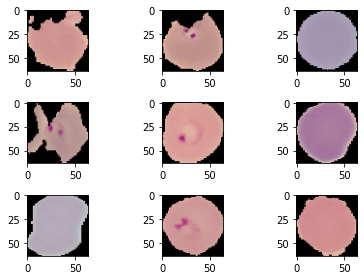

In [ ]:
# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[random.randint(0,trainX.shape[0])]);
# show the figure
plt.tight_layout()
plt.show()

### Training Data

In [ ]:
model = define_model(input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3]),**model_params)

In [ ]:
print('Load Model')
print('-------------------')
csv_logger = CSVLogger(folder + set_name + '.log', separator=',', append=False)
try:
  model = load_model(folder + set_name + '.h5')
  print('Success Load Model')
  print('-------------------')
except:
  print('Model not found in directory\nCreating new Model')
  print('-------------------')
  model.fit(trainX, trainY, validation_data=(testX, testY),callbacks=[csv_logger], **fit_params)
  model.save(folder + set_name + '.h5')
  print('Model Created and Saved')
  print('-------------------')

Load Model
-------------------
Success Load Model
-------------------


### Plot diagnostic learning curves

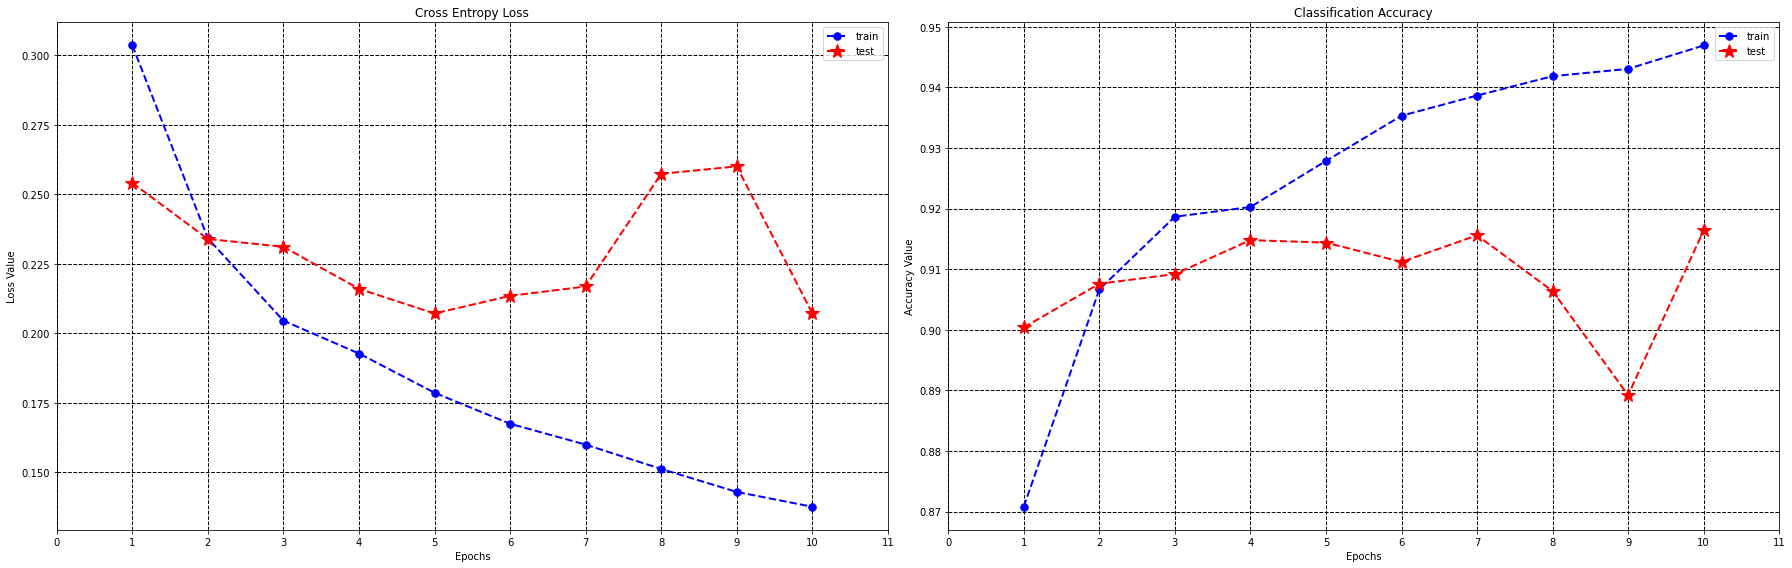

In [ ]:
log_data = pd.read_csv(folder + set_name + '.log', sep=',', engine='python')
summarize_diagnostics(log_data)

In [ ]:
#ini buat training :
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=1)
eval_acc_train.append(train_accuracy)
eval_loss_train.append(train_loss)

#ini buat testing :
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=1)
eval_acc_test.append(test_accuracy)
eval_loss_test.append(test_loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 34s 1s/step - loss: 0.1974 - accuracy: 0.9280


### Prediction

In [ ]:
predictions = model.predict(testX, fit_params['batch_size'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Rescale output Prediction into 0.0 or 1.0 value

In [ ]:
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

(1000, 1)

Reshape TestY

In [ ]:
testY = testY.reshape(testY.shape[0],1)

### Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[443,  65],
       [ 28, 464]])

### Classification Report

In [ ]:
target_names=['Parasitized','Uninfected']

print(classification_report(testY,predictions,target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.94      0.87      0.91       508
  Uninfected       0.88      0.94      0.91       492

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
BS_acc.append(acc)
print('Accuracy : %.5f' % acc)

Accuracy : 0.90700


### Heatmap

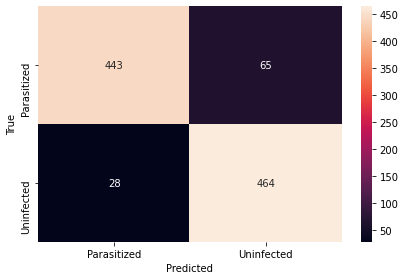

In [ ]:
x_axis_labels = ['Parasitized','Uninfected']
y_axis_labels = ['Parasitized','Uninfected']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Batch_Size 16
Resize 64, Citra Asli, Optimizer Adam, LR = , Epochs = 10

In [ ]:
set_name = 'Resize '+best_resize_name+',Citra '+best_citra_name+',Optimizer '+best_optimizer+',LR '+best_learning_rate_name+',BS 16,Epochs 10'

In [ ]:
photos = best_citra

optimizer = best_optimizer
learning_rate = best_learning_rate
batch_size = 16
epochs = 10
dropout = .0
dropout_end =.0

In [ ]:
model_params = dict(optimizer=optimizer,learning_rate=learning_rate,dropout=dropout,dropout_end=dropout_end)
model_params

{'dropout': 0.0,
 'dropout_end': 0.0,
 'learning_rate': 0.001,
 'optimizer': 'Adam'}

In [ ]:
fit_params = dict(epochs=epochs,batch_size=batch_size)
fit_params

{'batch_size': 16, 'epochs': 10}

Split Data Image into Train and Test Data

In [ ]:
# Split the test data and training data
(trainX, testX, trainY, testY) = train_test_split(photos.copy(), labels.copy(), test_size=0.25, random_state = 0)
print(trainX.shape)
print(testX.shape)

(3000, 64, 64, 3)
(1000, 64, 64, 3)


Normalize our Image matrix into [0 .. 1] range

In [ ]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Image Preview

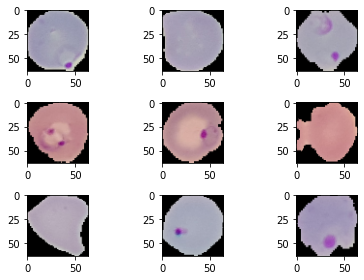

In [ ]:
# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[random.randint(0,trainX.shape[0])]);
# show the figure
plt.tight_layout()
plt.show()

### Training Data

In [ ]:
model = define_model(input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3]),**model_params)

In [ ]:
print('Load Model')
print('-------------------')
csv_logger = CSVLogger(folder + set_name + '.log', separator=',', append=False)
try:
  model = load_model(folder + set_name + '.h5')
  print('Success Load Model')
  print('-------------------')
except:
  print('Model not found in directory\nCreating new Model')
  print('-------------------')
  model.fit(trainX, trainY, validation_data=(testX, testY),callbacks=[csv_logger], **fit_params)
  model.save(folder + set_name + '.h5')
  print('Model Created and Saved')
  print('-------------------')

Load Model
-------------------
Success Load Model
-------------------


### Plot diagnostic learning curves

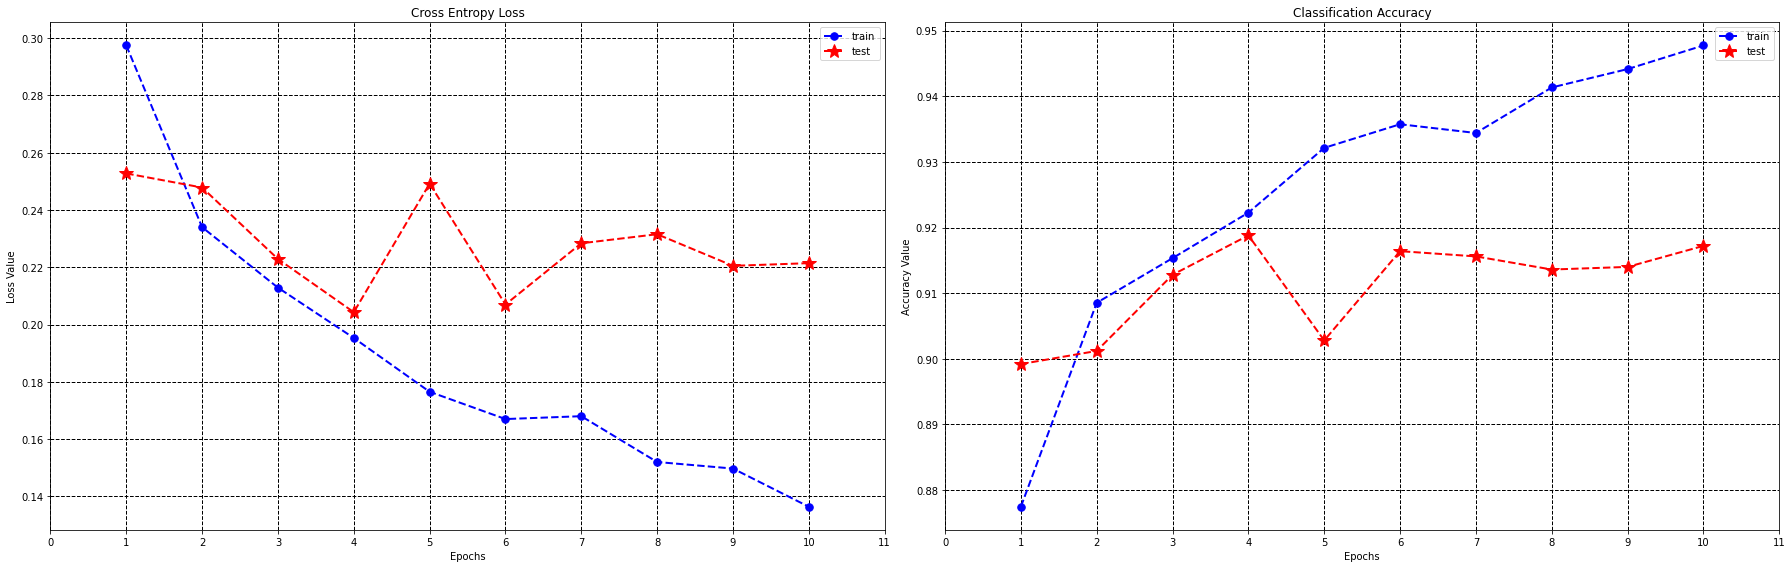

In [ ]:
log_data = pd.read_csv(folder + set_name + '.log', sep=',', engine='python')
summarize_diagnostics(log_data)

In [ ]:
#ini buat training :
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=1)
eval_acc_train.append(train_accuracy)
eval_loss_train.append(train_loss)

#ini buat testing :
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=1)
eval_acc_test.append(test_accuracy)
eval_loss_test.append(test_loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 34s 1s/step - loss: 0.1974 - accuracy: 0.9280


### Prediction

In [ ]:
predictions = model.predict(testX, fit_params['batch_size'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Rescale output Prediction into 0.0 or 1.0 value

In [ ]:
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

(1000, 1)

Reshape TestY

In [ ]:
testY = testY.reshape(testY.shape[0],1)

### Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[474,  34],
       [ 38, 454]])

### Classification Report

In [ ]:
target_names=['Parasitized','Uninfected']

print(classification_report(testY,predictions,target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.93      0.93      0.93       508
  Uninfected       0.93      0.92      0.93       492

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
BS_acc.append(acc)
print('Accuracy : %.5f' % acc)

Accuracy : 0.92800


### Heatmap

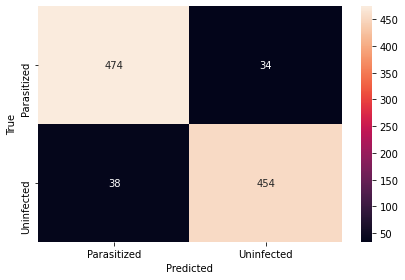

In [ ]:
x_axis_labels = ['Parasitized','Uninfected']
y_axis_labels = ['Parasitized','Uninfected']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Batch_Size 32
Resize 64, Citra Asli, Optimizer Adam, LR = , Epochs = 10

In [ ]:
set_name = 'Resize '+best_resize_name+',Citra '+best_citra_name+',Optimizer '+best_optimizer+',LR '+best_learning_rate_name+',BS 32,Epochs 10'

In [ ]:
photos = best_citra

optimizer = best_optimizer
learning_rate = best_learning_rate
batch_size = 32
epochs = 10
dropout = .0
dropout_end =.0

In [ ]:
model_params = dict(optimizer=optimizer,learning_rate=learning_rate,dropout=dropout,dropout_end=dropout_end)
model_params

{'dropout': 0.0,
 'dropout_end': 0.0,
 'learning_rate': 0.001,
 'optimizer': 'Adam'}

In [ ]:
fit_params = dict(epochs=epochs,batch_size=batch_size)
fit_params

{'batch_size': 32, 'epochs': 10}

Split Data Image into Train and Test Data

In [ ]:
# Split the test data and training data
(trainX, testX, trainY, testY) = train_test_split(photos.copy(), labels.copy(), test_size=0.25, random_state = 0)
print(trainX.shape)
print(testX.shape)

(3000, 64, 64, 3)
(1000, 64, 64, 3)


Normalize our Image matrix into [0 .. 1] range

In [ ]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Image Preview

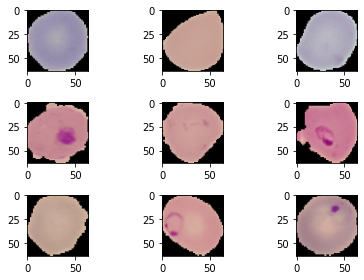

In [ ]:
# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[random.randint(0,trainX.shape[0])]);
# show the figure
plt.tight_layout()
plt.show()

### Training Data

In [ ]:
model = define_model(input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3]),**model_params)

In [ ]:
print('Load Model')
print('-------------------')
csv_logger = CSVLogger(folder + set_name + '.log', separator=',', append=False)
try:
  model = load_model(folder + set_name + '.h5')
  print('Success Load Model')
  print('-------------------')
except:
  print('Model not found in directory\nCreating new Model')
  print('-------------------')
  model.fit(trainX, trainY, validation_data=(testX, testY),callbacks=[csv_logger], **fit_params)
  model.save(folder + set_name + '.h5')
  print('Model Created and Saved')
  print('-------------------')

Load Model
-------------------
Success Load Model
-------------------


### Plot diagnostic learning curves

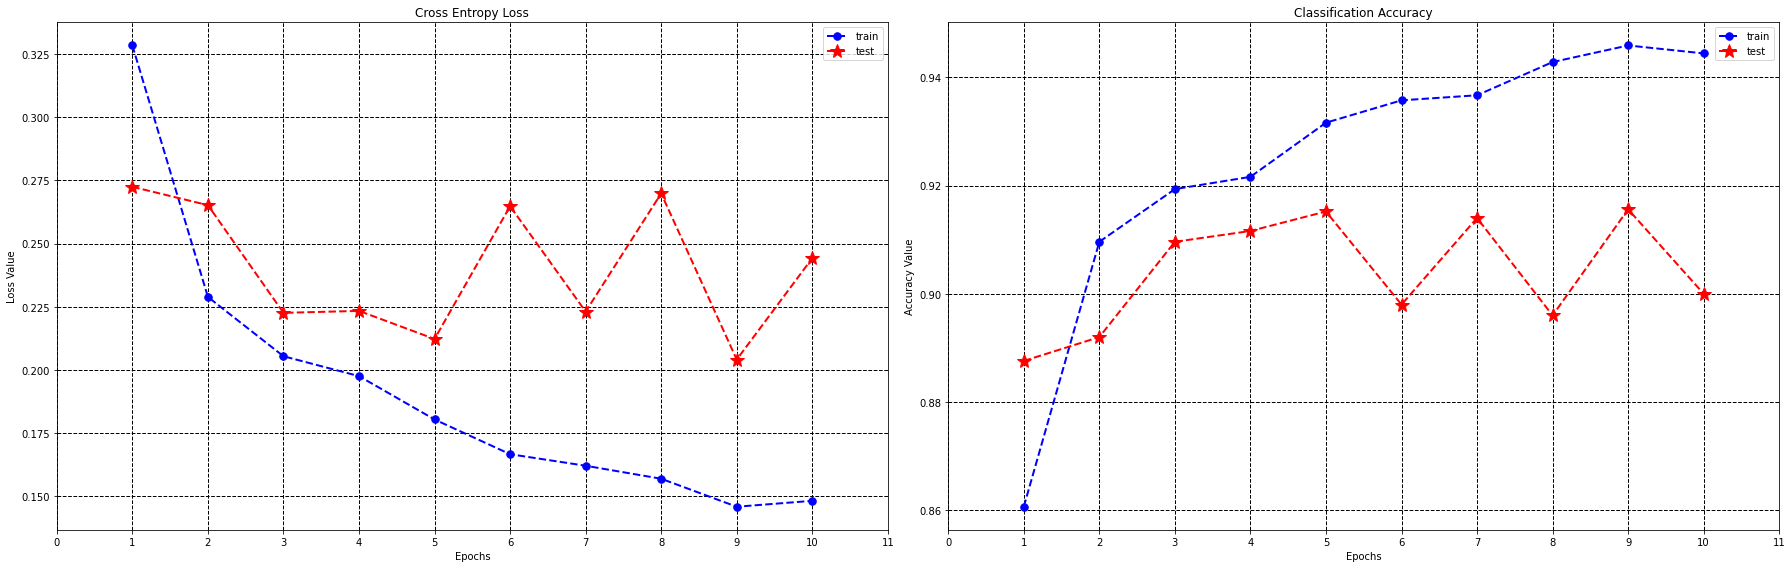

In [ ]:
log_data = pd.read_csv(folder + set_name + '.log', sep=',', engine='python')
summarize_diagnostics(log_data)

In [ ]:
#ini buat training :
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=1)
eval_acc_train.append(train_accuracy)
eval_loss_train.append(train_loss)

#ini buat testing :
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=1)
eval_acc_test.append(test_accuracy)
eval_loss_test.append(test_loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 34s 1s/step - loss: 0.1974 - accuracy: 0.9280


### Prediction

In [ ]:
predictions = model.predict(testX, fit_params['batch_size'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Rescale output Prediction into 0.0 or 1.0 value

In [ ]:
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

(1000, 1)

Reshape TestY

In [ ]:
testY = testY.reshape(testY.shape[0],1)

### Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[483,  25],
       [ 59, 433]])

### Classification Report

In [ ]:
target_names=['Parasitized','Uninfected']

print(classification_report(testY,predictions,target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.89      0.95      0.92       508
  Uninfected       0.95      0.88      0.91       492

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
BS_acc.append(acc)
print('Accuracy : %.5f' % acc)

Accuracy : 0.91600


### Heatmap

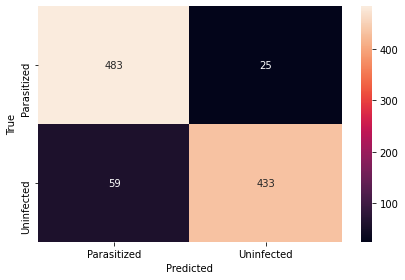

In [ ]:
x_axis_labels = ['Parasitized','Uninfected']
y_axis_labels = ['Parasitized','Uninfected']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Analisis Batch_Size

### Based on Training Evaluate

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


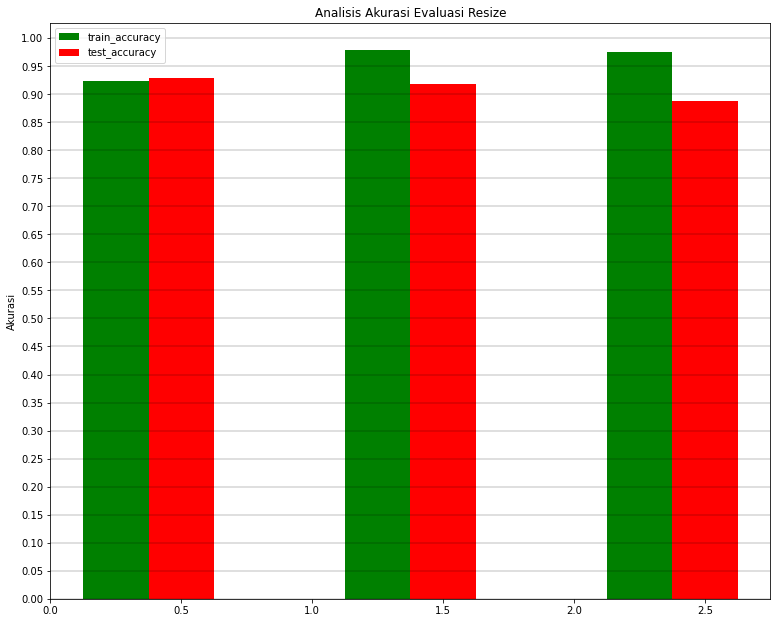

In [ ]:
ind = 0
width = 0.25

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind + 0.25, eval_acc_train[0], width, color='g')
ax.bar(ind + 0.5, eval_acc_test[0], width, color='r')
ax.bar(ind + 1.25, eval_acc_train[1], width, color='g')
ax.bar(ind + 1.5, eval_acc_test[1], width, color='r')
ax.bar(ind + 2.25, eval_acc_train[2], width, color='g')
ax.bar(ind + 2.5, eval_acc_test[2], width, color='r')

ax.set_ylabel('Akurasi')
ax.set_title('Analisis Akurasi Evaluasi Resize')
ax.set_yticks(np.arange(0, 1.05, 0.05))
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.25)
ax.legend(labels=['train_accuracy','test_accuracy'])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


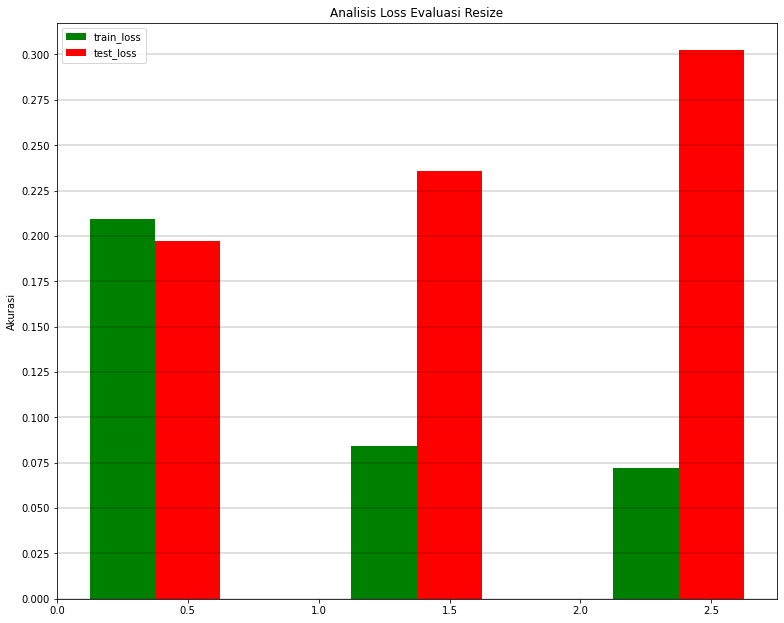

In [ ]:
ind = 0
width = 0.25

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind + 0.25, eval_loss_train[0], width, color='g')
ax.bar(ind + 0.5, eval_loss_test[0], width, color='r')
ax.bar(ind + 1.25, eval_loss_train[1], width, color='g')
ax.bar(ind + 1.5, eval_loss_test[1], width, color='r')
ax.bar(ind + 2.25, eval_loss_train[2], width, color='g')
ax.bar(ind + 2.5, eval_loss_test[2], width, color='r')

ax.set_ylabel('Akurasi')
ax.set_title('Analisis Loss Evaluasi Resize')
ax.set_yticks(np.arange(0, 0.325, 0.025))
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.25)
ax.legend(labels=['train_loss','test_loss'])

plt.tight_layout()
plt.show()

### Based on Predictions Accuracy

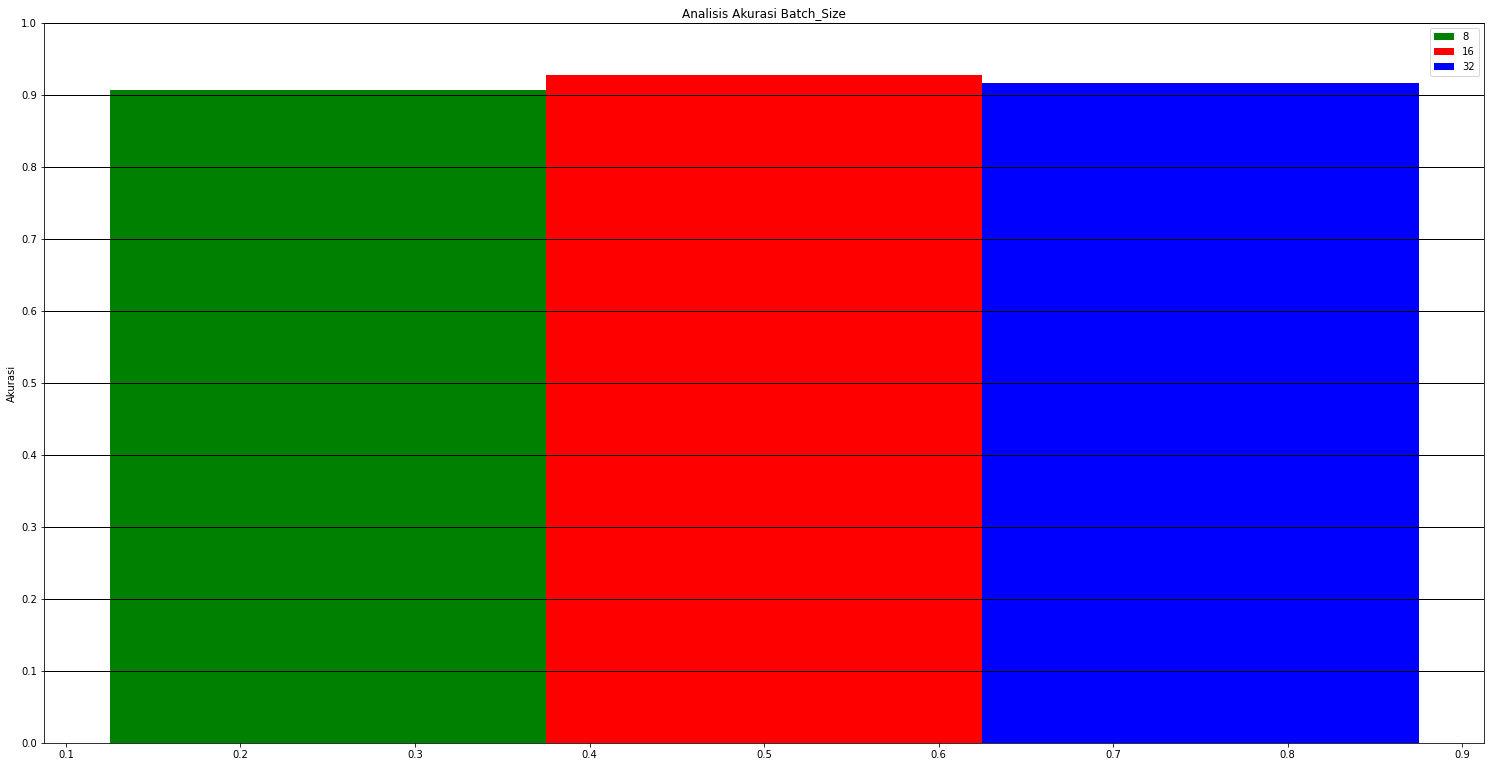

In [ ]:
ind = 0
width = 0.25
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind + 0.25, BS_acc[0], width, color='g')
ax.bar(ind + 0.5, BS_acc[1], width, color='r')
ax.bar(ind + 0.75, BS_acc[2], width, color='b')

ax.set_ylabel('Akurasi')
ax.set_title('Analisis Akurasi Batch_Size')
ax.set_yticks(np.arange(0, 1.1, 0.1))
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 1)
ax.legend(labels=['8','16', '32'])
plt.show()

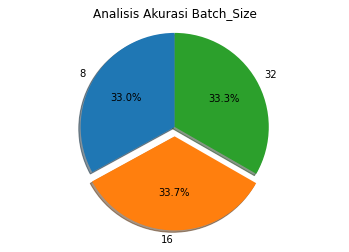

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
label = '8','16', '32'
sizes = BS_acc
explode = [0 if i != max(sizes) else 0.1 for i in sizes]

fig1, ax1 = plt.subplots()
plt.title('Analisis Akurasi Batch_Size')
ax1.pie(sizes, explode=explode, labels=label, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
Batch_sizes = [8,16,32]
best_batch_size = Batch_sizes[np.argmax(BS_acc)]
best_batch_size_name = str(best_batch_size)

In [ ]:
print('Best Batch_Size : ',best_batch_size)

Best Batch_Size :  16


# 6.**Epochs**

In [ ]:
Epochs_acc = []
eval_acc_train,eval_loss_train = [],[]
eval_acc_test,eval_loss_test = [],[]

## Epochs 10
Resize 64, Citra Asli, Optimizer Adam, LR = , Epochs = 10

In [ ]:
set_name = 'Resize '+best_resize_name+',Citra '+best_citra_name+',Optimizer '+best_optimizer+',LR '+best_learning_rate_name+',BS '+best_batch_size_name+',Epochs 10'

In [ ]:
photos = best_citra

optimizer = best_optimizer
learning_rate = best_learning_rate
batch_size = best_batch_size
epochs = 10
dropout = .0
dropout_end =.0

In [ ]:
model_params = dict(optimizer=optimizer,learning_rate=learning_rate,dropout=dropout,dropout_end=dropout_end)
model_params

{'dropout': 0.0,
 'dropout_end': 0.0,
 'learning_rate': 0.001,
 'optimizer': 'Adam'}

In [ ]:
fit_params = dict(epochs=epochs,batch_size=batch_size)
fit_params

{'batch_size': 16, 'epochs': 10}

Split Data Image into Train and Test Data

In [ ]:
# Split the test data and training data
(trainX, testX, trainY, testY) = train_test_split(photos.copy(), labels.copy(), test_size=0.25, random_state = 0)
print(trainX.shape)
print(testX.shape)

(3000, 64, 64, 3)
(1000, 64, 64, 3)


Normalize our Image matrix into [0 .. 1] range

In [ ]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Image Preview

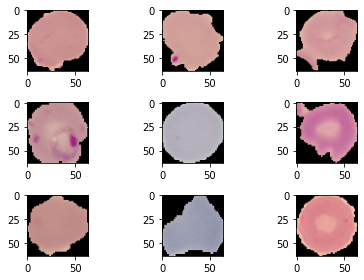

In [ ]:
# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[random.randint(0,trainX.shape[0])]);
# show the figure
plt.tight_layout()
plt.show()

### Training Data

In [ ]:
model = define_model(input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3]),**model_params)

In [ ]:
print('Load Model')
print('-------------------')
csv_logger = CSVLogger(folder + set_name + '.log', separator=',', append=False)
try:
  model = load_model(folder + set_name + '.h5')
  print('Success Load Model')
  print('-------------------')
except:
  print('Model not found in directory\nCreating new Model')
  print('-------------------')
  model.fit(trainX, trainY, validation_data=(testX, testY),callbacks=[csv_logger], **fit_params)
  model.save(folder + set_name + '.h5')
  print('Model Created and Saved')
  print('-------------------')

Load Model
-------------------
Success Load Model
-------------------


### Plot diagnostic learning curves

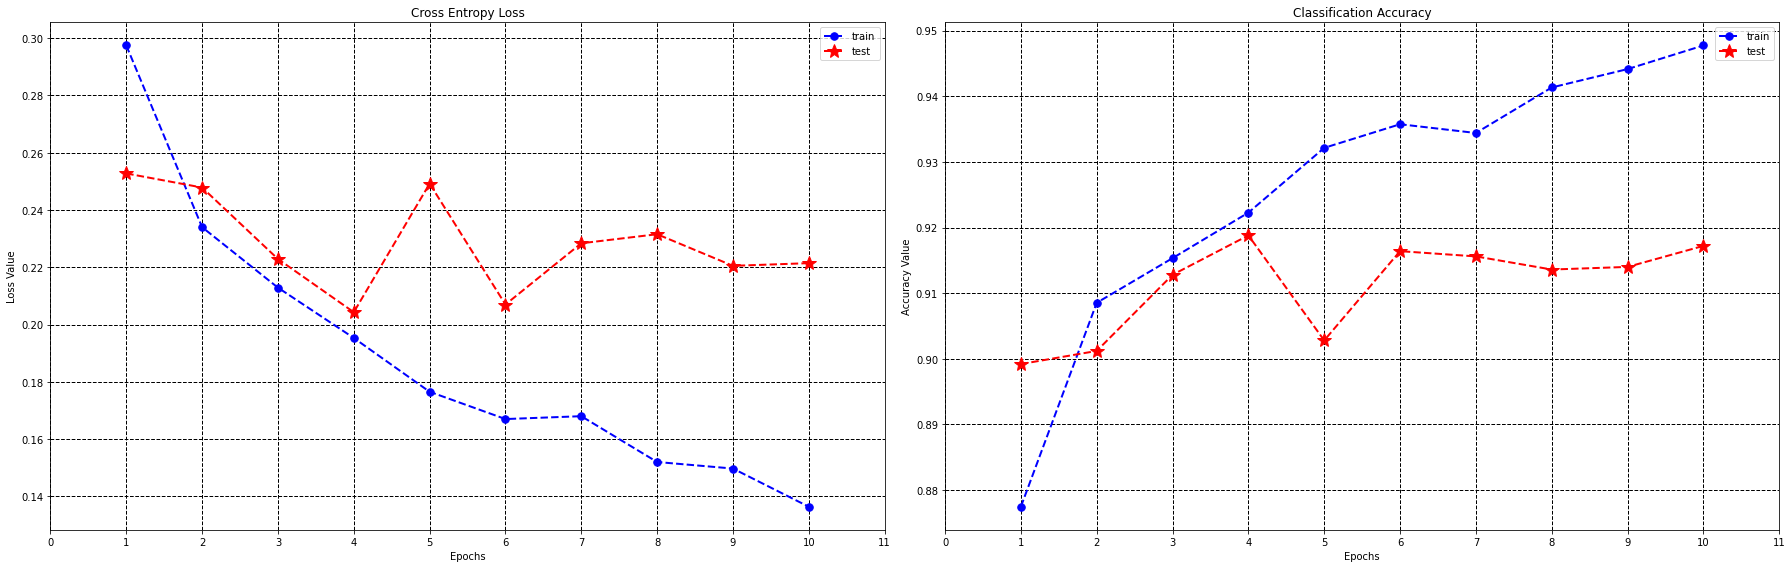

In [ ]:
log_data = pd.read_csv(folder + set_name + '.log', sep=',', engine='python')
summarize_diagnostics(log_data)

In [ ]:
#ini buat training :
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=1)
eval_acc_train.append(train_accuracy)
eval_loss_train.append(train_loss)

#ini buat testing :
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=1)
eval_acc_test.append(test_accuracy)
eval_loss_test.append(test_loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 34s 1s/step - loss: 0.1974 - accuracy: 0.9280


### Prediction

In [ ]:
predictions = model.predict(testX, fit_params['batch_size'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Rescale output Prediction into 0.0 or 1.0 value

In [ ]:
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

(1000, 1)

Reshape TestY

In [ ]:
testY = testY.reshape(testY.shape[0],1)

### Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[474,  34],
       [ 38, 454]])

### Classification Report

In [ ]:
target_names=['Parasitized','Uninfected']

print(classification_report(testY,predictions,target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.93      0.93      0.93       508
  Uninfected       0.93      0.92      0.93       492

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
Epochs_acc.append(acc)
print('Accuracy : %.5f' % acc)

Accuracy : 0.92800


### Heatmap

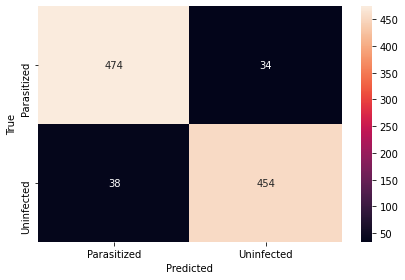

In [ ]:
x_axis_labels = ['Parasitized','Uninfected']
y_axis_labels = ['Parasitized','Uninfected']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Epochs 15
Resize 64, Citra Asli, Optimizer Adam, LR = , Epochs = 10

In [ ]:
set_name = 'Resize '+best_resize_name+',Citra '+best_citra_name+',Optimizer '+best_optimizer+',LR '+best_learning_rate_name+',BS '+best_batch_size_name+',Epochs 15'

In [ ]:
photos = best_citra

optimizer = best_optimizer
learning_rate = best_learning_rate
batch_size = best_batch_size
epochs = 15
dropout = .0
dropout_end =.0

In [ ]:
model_params = dict(optimizer=optimizer,learning_rate=learning_rate,dropout=dropout,dropout_end=dropout_end)
model_params

{'dropout': 0.0,
 'dropout_end': 0.0,
 'learning_rate': 0.001,
 'optimizer': 'Adam'}

In [ ]:
fit_params = dict(epochs=epochs,batch_size=batch_size)
fit_params

{'batch_size': 16, 'epochs': 15}

Split Data Image into Train and Test Data

In [ ]:
# Split the test data and training data
(trainX, testX, trainY, testY) = train_test_split(photos, labels, test_size=0.25, random_state = 0)
print(trainX.shape)
print(testX.shape)

(3000, 64, 64, 3)
(1000, 64, 64, 3)


Normalize our Image matrix into [0 .. 1] range

In [ ]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Image Preview

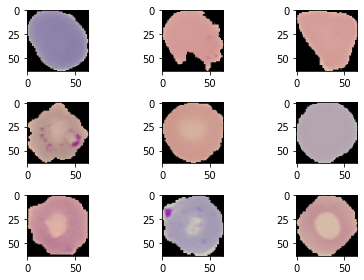

In [ ]:
# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[random.randint(0,trainX.shape[0])]);
# show the figure
plt.tight_layout()
plt.show()

### Training Data

In [ ]:
model = define_model(input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3]),**model_params)

In [ ]:
print('Load Model')
print('-------------------')
csv_logger = CSVLogger(folder + set_name + '.log', separator=',', append=False)
try:
  model = load_model(folder + set_name + '.h5')
  print('Success Load Model')
  print('-------------------')
except:
  print('Model not found in directory\nCreating new Model')
  print('-------------------')
  model.fit(trainX, trainY, validation_data=(testX, testY),callbacks=[csv_logger], **fit_params)
  model.save(folder + set_name + '.h5')
  print('Model Created and Saved')
  print('-------------------')

Load Model
-------------------
Success Load Model
-------------------


### Plot diagnostic learning curves

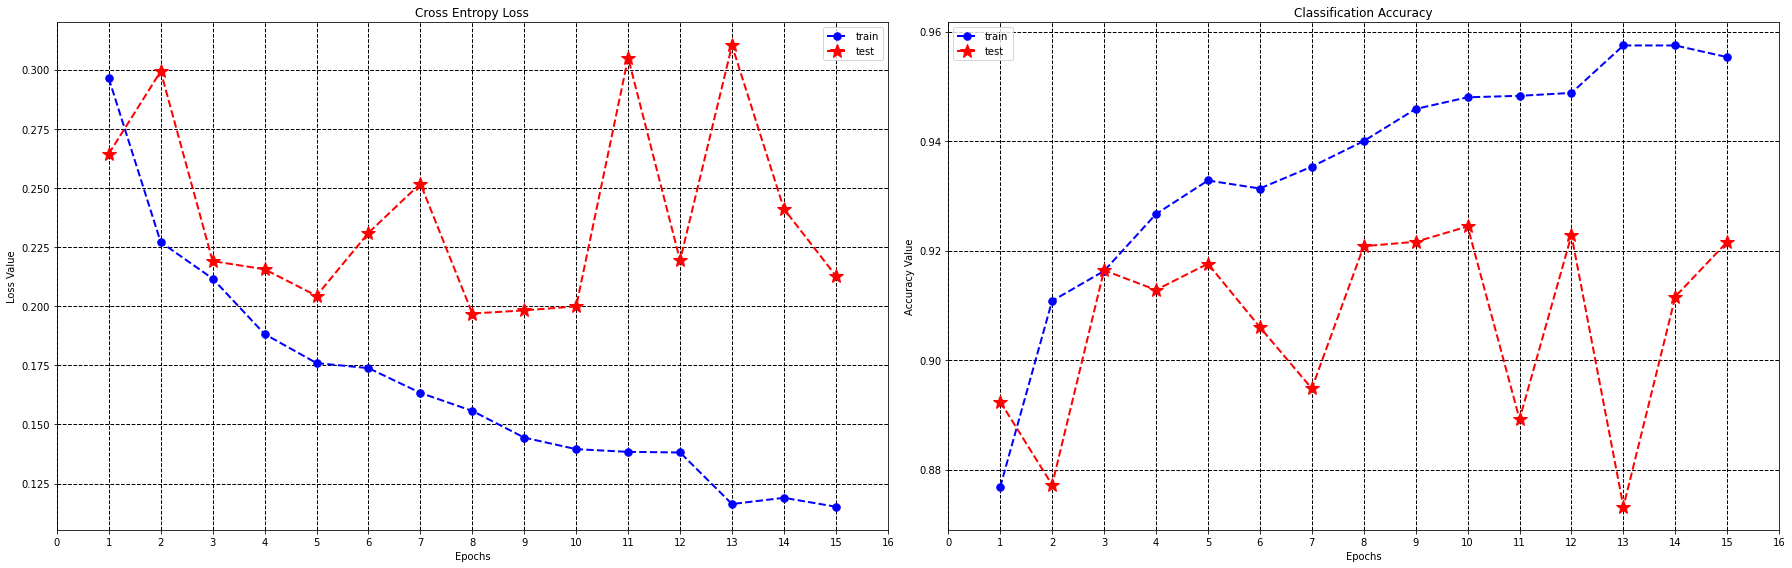

In [ ]:
log_data = pd.read_csv(folder + set_name + '.log', sep=',', engine='python')
summarize_diagnostics(log_data)

In [ ]:
#ini buat training :
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=1)
eval_acc_train.append(train_accuracy)
eval_loss_train.append(train_loss)

#ini buat testing :
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=1)
eval_acc_test.append(test_accuracy)
eval_loss_test.append(test_loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 34s 1s/step - loss: 0.1974 - accuracy: 0.9280


### Prediction

In [ ]:
predictions = model.predict(testX, fit_params['batch_size'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Rescale output Prediction into 0.0 or 1.0 value

In [ ]:
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

(1000, 1)

Reshape TestY

In [ ]:
testY = testY.reshape(testY.shape[0],1)

### Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[472,  36],
       [ 37, 455]])

### Classification Report

In [ ]:
target_names=['Parasitized','Uninfected']

print(classification_report(testY,predictions,target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.93      0.93      0.93       508
  Uninfected       0.93      0.92      0.93       492

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
Epochs_acc.append(acc)
print('Accuracy : %.5f' % acc)

Accuracy : 0.92700


### Heatmap

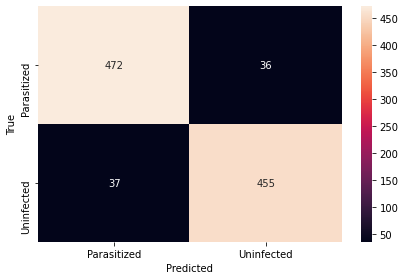

In [ ]:
x_axis_labels = ['Parasitized','Uninfected']
y_axis_labels = ['Parasitized','Uninfected']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Epochs 25
Resize 64, Citra Asli, Optimizer Adam, LR = , Epochs = 10

In [ ]:
set_name = 'Resize '+best_resize_name+',Citra '+best_citra_name+',Optimizer '+best_optimizer+',LR '+best_learning_rate_name+',BS '+best_batch_size_name+',Epochs 25'

In [ ]:
photos = best_citra

optimizer = best_optimizer
learning_rate = best_learning_rate
batch_size = best_batch_size
epochs = 25
dropout = .0
dropout_end =.0

In [ ]:
model_params = dict(optimizer=optimizer,learning_rate=learning_rate,dropout=dropout,dropout_end=dropout_end)
model_params

{'dropout': 0.0,
 'dropout_end': 0.0,
 'learning_rate': 0.001,
 'optimizer': 'Adam'}

In [ ]:
fit_params = dict(epochs=epochs,batch_size=batch_size)
fit_params

{'batch_size': 16, 'epochs': 25}

Split Data Image into Train and Test Data

In [ ]:
# Split the test data and training data
(trainX, testX, trainY, testY) = train_test_split(photos.copy(), labels.copy(), test_size=0.25, random_state = 0)
print(trainX.shape)
print(testX.shape)

(3000, 64, 64, 3)
(1000, 64, 64, 3)


Normalize our Image matrix into [0 .. 1] range

In [ ]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

Image Preview

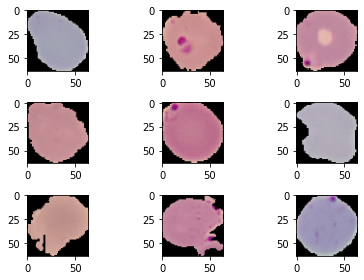

In [ ]:
# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[random.randint(0,trainX.shape[0])]);
# show the figure
plt.tight_layout()
plt.show()

### Training Data

In [ ]:
model = define_model(input_shape=(trainX.shape[1],trainX.shape[2],trainX.shape[3]),**model_params)

In [ ]:
print('Load Model')
print('-------------------')
csv_logger = CSVLogger(folder + set_name + '.log', separator=',', append=False)
try:
  model = load_model(folder + set_name + '.h5')
  print('Success Load Model')
  print('-------------------')
except:
  print('Model not found in directory\nCreating new Model')
  print('-------------------')
  model.fit(trainX, trainY, validation_data=(testX, testY),callbacks=[csv_logger], **fit_params)
  model.save(folder + set_name + '.h5')
  print('Model Created and Saved')
  print('-------------------')

Load Model
-------------------
Success Load Model
-------------------


### Plot diagnostic learning curves

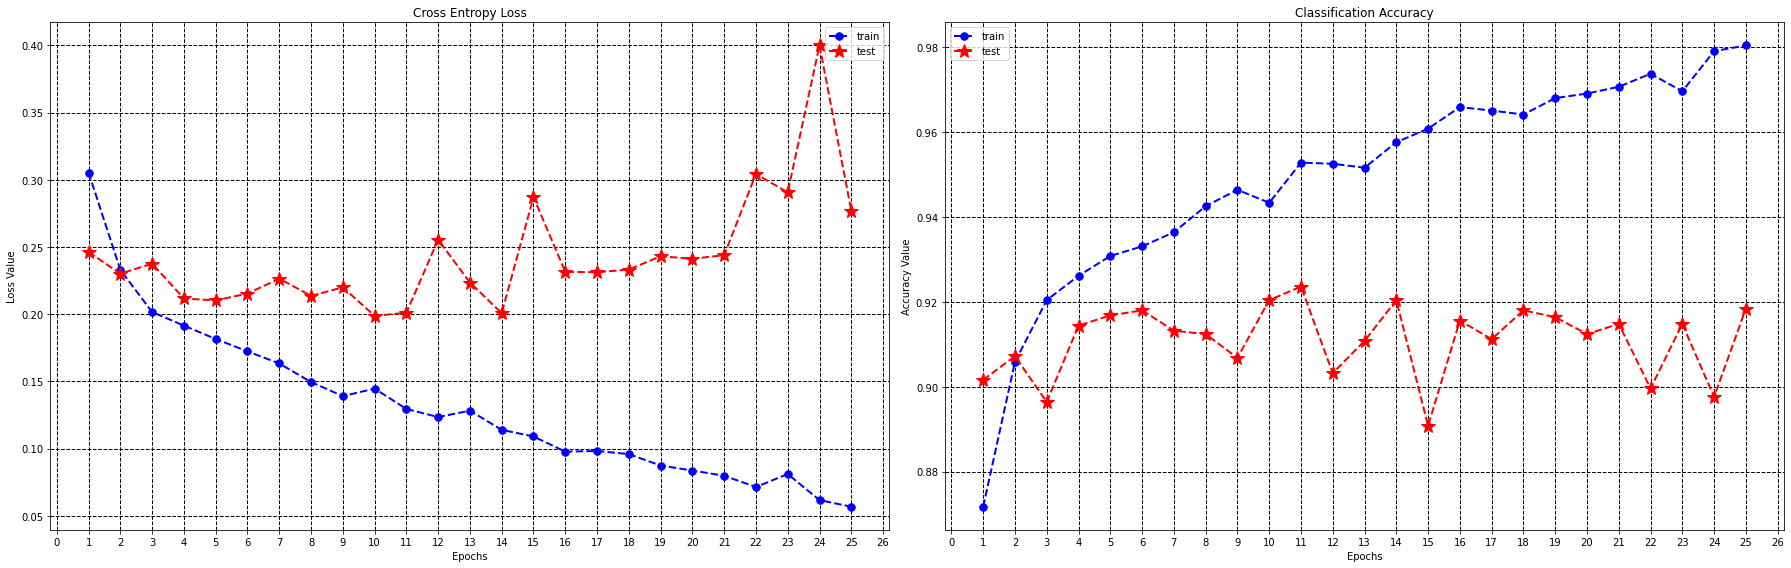

In [ ]:
log_data = pd.read_csv(folder + set_name + '.log', sep=',', engine='python')
summarize_diagnostics(log_data)

In [ ]:
#ini buat training :
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=1)
eval_acc_train.append(train_accuracy)
eval_loss_train.append(train_loss)

#ini buat testing :
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=1)
eval_acc_test.append(test_accuracy)
eval_loss_test.append(test_loss)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 34s 1s/step - loss: 0.1974 - accuracy: 0.9280


### Prediction

In [ ]:
predictions = model.predict(testX, fit_params['batch_size'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Rescale output Prediction into 0.0 or 1.0 value

In [ ]:
for i in range(len(predictions)):
  if predictions[i] < 0.5:
    predictions[i] = 0.0
  else:
    predictions[i] = 1.0
predictions.shape

(1000, 1)

Reshape TestY

In [ ]:
testY = testY.reshape(testY.shape[0],1)

### Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(testY,predictions)
confusion_matrix

array([[470,  38],
       [ 34, 458]])

### Classification Report

In [ ]:
target_names=['Parasitized','Uninfected']

print(classification_report(testY,predictions,target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.93      0.93      0.93       508
  Uninfected       0.92      0.93      0.93       492

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [ ]:
acc = classification_report(testY,predictions,target_names=target_names,output_dict=True)['accuracy']
Epochs_acc.append(acc)
print('Accuracy : %.5f' % acc)

Accuracy : 0.92800


### Heatmap

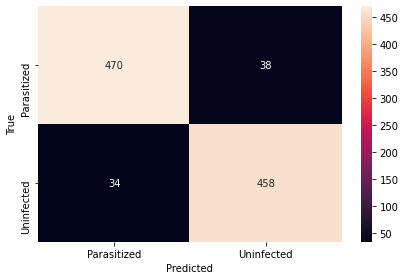

In [ ]:
x_axis_labels = ['Parasitized','Uninfected']
y_axis_labels = ['Parasitized','Uninfected']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Analisis Epochs

### Based on Training Evaluate

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


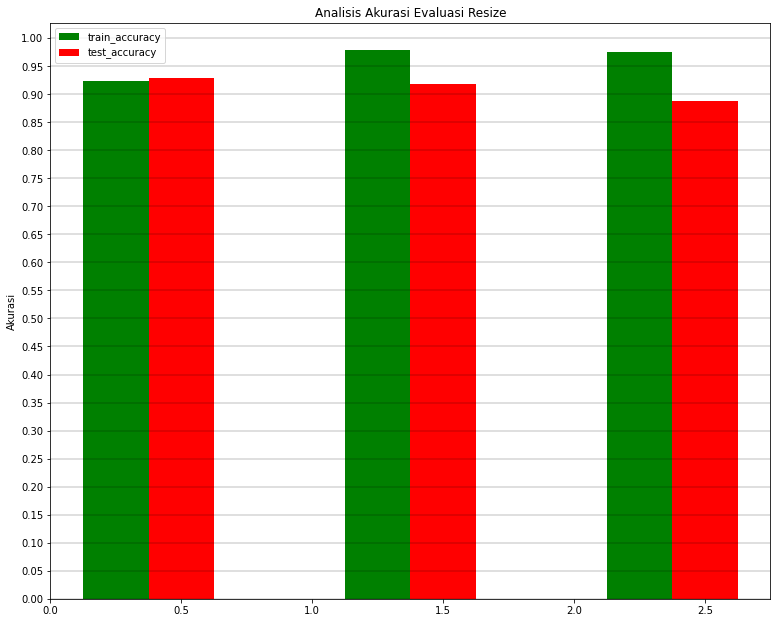

In [ ]:
ind = 0
width = 0.25

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind + 0.25, eval_acc_train[0], width, color='g')
ax.bar(ind + 0.5, eval_acc_test[0], width, color='r')
ax.bar(ind + 1.25, eval_acc_train[1], width, color='g')
ax.bar(ind + 1.5, eval_acc_test[1], width, color='r')
ax.bar(ind + 2.25, eval_acc_train[2], width, color='g')
ax.bar(ind + 2.5, eval_acc_test[2], width, color='r')

ax.set_ylabel('Akurasi')
ax.set_title('Analisis Akurasi Evaluasi Resize')
ax.set_yticks(np.arange(0, 1.05, 0.05))
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.25)
ax.legend(labels=['train_accuracy','test_accuracy'])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


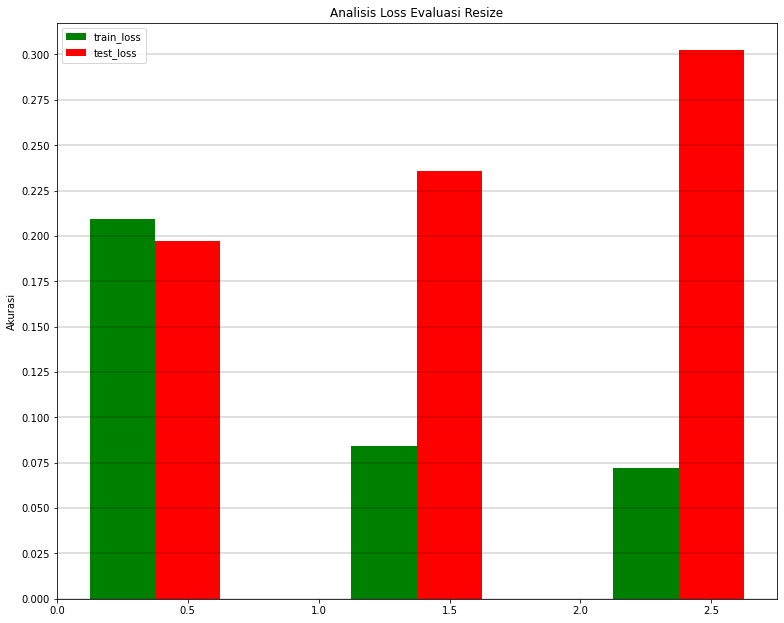

In [ ]:
ind = 0
width = 0.25

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind + 0.25, eval_loss_train[0], width, color='g')
ax.bar(ind + 0.5, eval_loss_test[0], width, color='r')
ax.bar(ind + 1.25, eval_loss_train[1], width, color='g')
ax.bar(ind + 1.5, eval_loss_test[1], width, color='r')
ax.bar(ind + 2.25, eval_loss_train[2], width, color='g')
ax.bar(ind + 2.5, eval_loss_test[2], width, color='r')

ax.set_ylabel('Akurasi')
ax.set_title('Analisis Loss Evaluasi Resize')
ax.set_yticks(np.arange(0, 0.325, 0.025))
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 0.25)
ax.legend(labels=['train_loss','test_loss'])

plt.tight_layout()
plt.show()

### Based on Predictions Accuracy

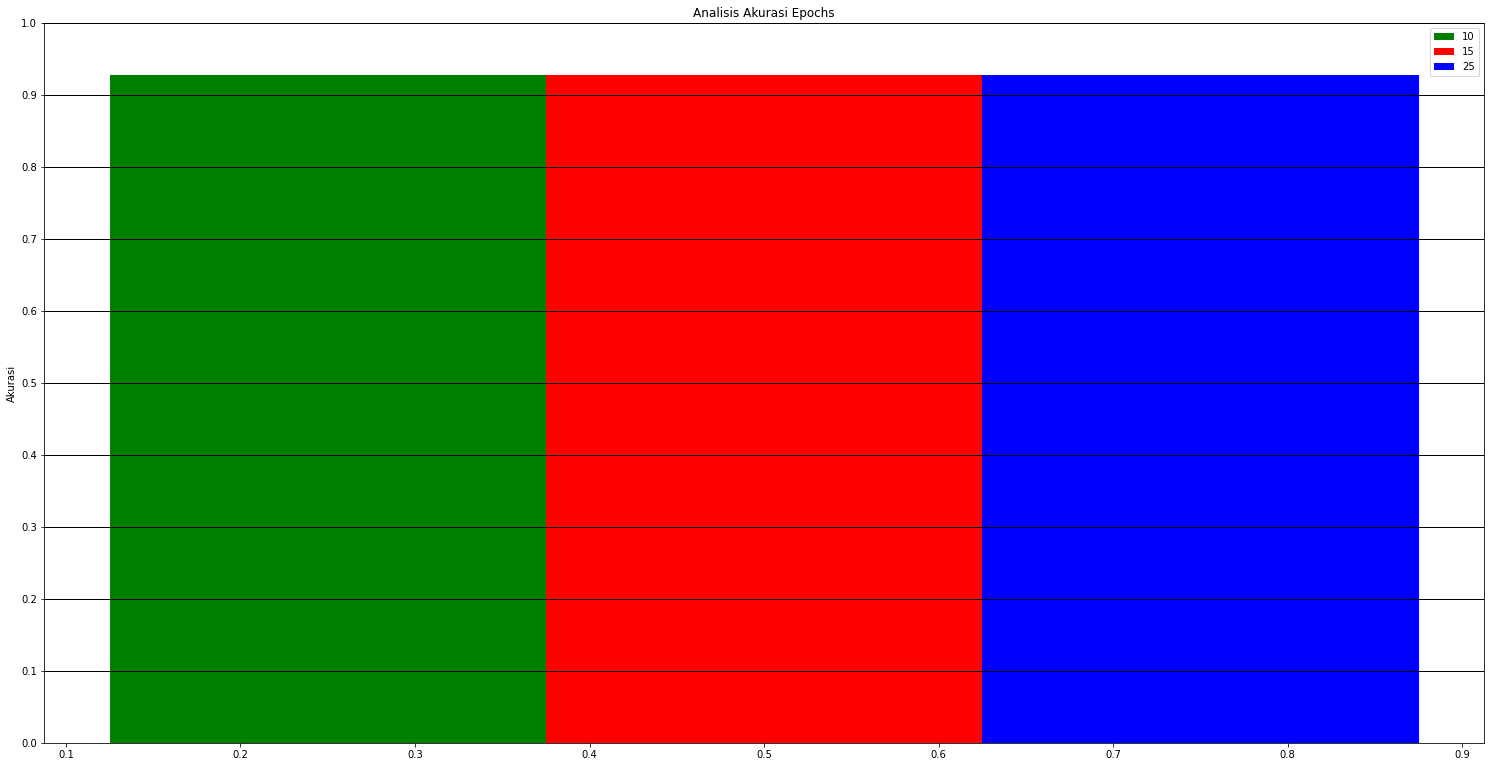

In [ ]:
ind = 0
width = 0.25
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(ind + 0.25, Epochs_acc[0], width, color='g')
ax.bar(ind + 0.5, Epochs_acc[1], width, color='r')
ax.bar(ind + 0.75, Epochs_acc[2], width, color='b')

ax.set_ylabel('Akurasi')
ax.set_title('Analisis Akurasi Epochs')
ax.set_yticks(np.arange(0, 1.1, 0.1))
plt.grid(axis = 'y', color = 'black', linestyle = '-', linewidth = 1)
ax.legend(labels=['10','15', '25'])
plt.show()

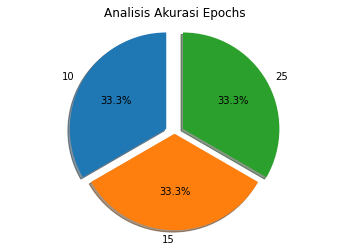

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
label = '10','15', '25'
sizes = Epochs_acc
explode = [0 if i != max(sizes) else 0.1 for i in sizes]

fig1, ax1 = plt.subplots()
plt.title('Analisis Akurasi Epochs')
ax1.pie(sizes, explode=explode, labels=label, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
Epoch = [10,15,25]
best_epochs = Epoch[np.argmax(Epochs_acc)]

In [ ]:
print('Best Epochs : ',best_epochs)

Best Epochs :  10
